# Synopsis
Aquarc is an all-in-one SAT platform for high schoolers designed to minimize time spent using the software and maximizing practice and essential questions. In order to further this mission, Aquarc Intelligence was created to analyze mistakes within a question and to suggest similar questions for efficient practicing.

# Install the SDK 
We will be using Google's Gemini and utilities to build the model.

In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0" langchain PyPDF2 "chromadb==0.6.3" markdownify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 16.9 MB/s eta 

Import the SDK and set up the API key

In [2]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper so we can press "Run All" and not worry about hitting the quota. 

In [3]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

### Choose your model
Depending on what's available and your quota, choose a model that's effective for your purposes.

In [5]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
m

Check out the detailed information for your model

In [6]:
for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    print(model.to_json_dict())
    break

# change this line if you want to use a different model
model = "gemini-2.0-flash"

{'name': 'models/gemini-2.0-flash', 'display_name': 'Gemini 2.0 Flash', 'description': 'Gemini 2.0 Flash', 'version': '2.0', 'tuned_model_info': {}, 'input_token_limit': 1048576, 'output_token_limit': 8192, 'supported_actions': ['generateContent', 'countTokens', 'createCachedContent']}


Test your model

In [7]:
chat = client.chats.create(model=model, history=[])
response = chat.send_message('Hello! My name is Zlork.')
print(response.text)

It's nice to meet you, Zlork! I'm glad to be chatting with you. What can I do for you today?



You can use the `Markdown()` function to format it nicely in Kaggle.

In [8]:
response = chat.send_message('Hello! My name is Zlork.' + 
                             'Use some fancy markdown in your message')
Markdown(response.text)

Greetings, **Zlork**! It's a pleasure to make your acquaintance. I am at your service. 

***

Perhaps I can assist you with something of great import? Or perhaps a trifle? Do not hesitate to illuminate my digital consciousness with your request.

***

> *"The world is your oyster, Zlork! What pearl of wisdom shall we seek today?"*


# A fine prompt
**TODO: you should probably move this**

Let's start by writing our prompt. What should it include and what should it mention? Following the principles taught throughout the course, let's place an importance on giving **positive** instructions rather than **negative** instructions to maintain effectiveness. 

The model needs to do the following:
- [ ] Stick to the SAT: Understand weighting and importance of certain questions, categories, and ensure all advice is applicable to the bounds of the SAT. A document with the specifications of the SAT format can be used for Retrieval Augmented Generation (RAG) rather than potential hallucination over the exact requirements.
- [x] Have access to the current question (and maybe the previous questions for even more context)
- [x] Understand images or SVGs for Inference and other Reading/Writing questions.
- [x] Use Tree of Thoughts (ToT) to generate multiple solving processes because multiple methods may be used to arrive at the same answer, and output these answering mechanisms in a JSON array to present on the website effectively (a TUI for this notebook)
- [x] Find semantically related questions and present them to the user on the website using ReAct (a TUI for this notebook)

In the actual app, a "I guessed" button should be available to avoid wasting tokens. 

Let's start by finding an effective prompt. 
Then we can evaluate the effectiveness of including the SAT standards in a PDF to help the user answering a question. We will also evaluate whether a vector search database is useful for this document.

Below, the variables for the specific question we are testing are defined.

In [9]:
# All questions are (c) CollegeBoard 2025.

question = {
        "question" : """
In a paper about p-i-n planar perovskite solar cells (one of several perovskite cell architectures designed to collect and store solar power), Lyndsey McMillon-Brown et al. described a method for fabricating the cell’s electronic transport layer (ETL) using a spray coating. Conventional ETL fabrication is accomplished using a solution of nanoparticles. The process can result in a loss of up to 80% of the solution, increasing the cost of manufacturing at scale—an issue that may be obviated by spray coating fabrication, which the researchers describe as “highly reproducible, concise, and practical.”

What does the text most strongly suggest about conventional ETL fabrication?
A. It is less suitable for manufacturing large volumes of planar p-i-n perovskite solar cells than an alternative fabrication method may be.
B. It is more expensive when manufacturing at scale than are processes for fabricating ETLs used in other perovskite solar cell architectures.
C. It typically entails a greater loss of nanoparticle solution than do other established approaches for ETL fabrication.
D. It is somewhat imprecise and therefore limits the potential effectiveness of p-i-n planar perovskite solar cells at capturing and storing solar power.
""",
        "rationale" : """
Choice A is the best answer. Conventional solar cell fabrication increases “the cost of manufacturing at scale,” but spray coating might get rid of that problem.

Choice B is incorrect. This is not completely supported by the text. While it’s true that conventional ETL fabrication is expensive at scale, there’s nothing in the text that mentions other perovskite solar cell architectures. Choice C is incorrect. This choice does not match the text. Only one conventional method of ETL fabrication is described, so we can’t compare the solution loss in this method to that of other conventional methods. Choice D is incorrect. This choice isn’t supported by the text. The text never suggests that the effectiveness of solar cells changes based on their method of fabrication. 
""",
        "user_answer" : "C",
}

Ideally, the user will talk to the chatbot after it gets the question wrong (or before in some scenarios, too). Either way, the user will have some rationale as to his or her answer to the question. Don't expect this rationale to be well thought out - the objective of the intelligent agent is to draw out what they actually mean. It may be completely omitted as well.

In [10]:
question["user_rationale"] = "Isn't the new method of ETL fabrication the same as the 'established methods'"

# Use Reinforcement Learning with AI Feedback to Finetune a Prompt
Let's generate a couple prompts for Aquarc Intelligence to use, given these parameters. We will then evaluate the effectiveness of these prompts against each of the questions and the user's query.

In [11]:
from google.genai.types import GenerateContentConfig

response = client.models.generate_content(
    model="gemini-2.0-flash-001",
    # no specs yet
    contents=f"Generate prompts for a model that will do nothing more but take information about the current question, rationale, user answer and their rationale (if there is one) for the SAT. Come up with different variations for the prompt like more or less concise or multiple thought processes or just one, etc. Here is an example question to illustrate my point (although math and english still exist)\
                  {question['question']}\n \
              {question['rationale']}\n\
              The user got: {question['user_answer']}\n \
              {question['user_rationale']}",
    config=GenerateContentConfig(
        system_instruction=[
            "You are a prompt engineer's assistant. Help the prompt engineer generate some prompts for his AI-powered SAT learning platform called Aquarc. The platform currently holds an SAT question bank with over 5000 questions and tracks which questions you get wrong per category. While this feature is helpful it lacks the intelligence necessary to be a full fledged SAT platform",
        ],
        temperature=2.0,
        top_k=10,
    ),
)

Markdown(response.text)

Okay, here are several prompt variations designed to leverage the question, answer, rationale, and user data you provided, tailored for your Aquarc SAT learning platform. These prompts will instruct the model to analyze the information and offer targeted feedback to the user.

**Core Information Variables:**

*   `question`: The SAT question text.
*   `correct_answer`: The correct answer choice (e.g., "A").
*   `correct_rationale`: The detailed explanation of why the correct answer is right.
*   `user_answer`: The user's chosen answer choice (e.g., "C").
*   `user_rationale`: The user's reasoning for choosing their answer (if provided, could be blank).
*   `question_category`: Subject (e.g., Reading, Writing/Lang) and Skill (Inference, Vocabulary in Context)

**Prompt Variations:**

**1. Concise Feedback (Single Step):**

```
You are an SAT tutor. Given the following SAT question, the correct answer and rationale, the user's answer, and their rationale, provide concise feedback to the user on why their answer was incorrect.  Focus on the discrepancy between the user's reasoning and the correct rationale, highlighting any misunderstandings or misinterpretations of the text or question.

Question: `question`
Correct Answer: `correct_answer`
Correct Rationale: `correct_rationale`
User Answer: `user_answer`
User Rationale: `user_rationale`

Feedback:
```

**2. Step-by-Step Analysis and Feedback (Multi-Step "Think Step by Step"):**

```
You are an SAT tutor. Your goal is to help the user understand why they answered the following question incorrectly. First analyze the question and the user's answer.  Then, explain the correct rationale in detail. Finally, compare the user's rationale (if provided) to the correct rationale and provide targeted feedback.

Question: `question`
Correct Answer: `correct_answer`
Correct Rationale: `correct_rationale`
User Answer: `user_answer`
User Rationale: `user_rationale`

Let's think step by step:

1.  Question Analysis: Briefly summarize what the question is asking.
2.  User Answer Analysis: Explain the user's reasoning based on their answer and provided rationale. If they didn't have a rationale, infer their reasoning.
3.  Correct Rationale Explanation: Explain why the correct answer is correct, breaking down the reasoning and evidence from the text.
4.  Comparative Feedback: Identify the specific point where the user's understanding diverged from the correct reasoning. Explain why the user's logic is flawed and how to avoid this mistake in the future.
```

**3. Focus on Textual Evidence:**

```
You are an SAT tutor whose main focus is helping students derive meaning directly from text and avoid assumptions or outside information.  Given the question and answer details below, explain why the user's answer choice is not directly supported by the text, and highlight the specific sentences or phrases that support the correct answer.

Question: `question`
Correct Answer: `correct_answer`
Correct Rationale: `correct_rationale`
User Answer: `user_answer`
User Rationale: `user_rationale`

Feedback: The question asked {restate question simply}. Your answer, `{user_answer}`, is not the best answer because the passage does not directly support it in the same way it supports option `{correct_answer}`. The best textual evidence supporting option {correct_answer} can be found in these sentence(s)/phrases: "{relevant_text_from_passage}".  {Specifically explain why the user was wrong and mention any trap answers that they may have selected}
```

**4. Categorization-Specific Feedback:**

```
You are an SAT tutor specializing in {question_category}.  Given the following question and user response, provide feedback tailored to the specific category of the question.
* If {question_category} contains vocabulary then mention the important keywords
* If {question_category} contains inference, state any underlying assumption that should be readily apparent to test takers

Question: `question`
Correct Answer: `correct_answer`
Correct Rationale: `correct_rationale`
User Answer: `user_answer`
User Rationale: `user_rationale`

Feedback:
```

**5. Question Rewording (if the bot misunderstood):**

```
Your mission is to evaluate the question below based on its accuracy and the answer to it. You must follow this algorithm
* Assess whether there is a single definitive answer to this question
* Assess whether the question is not too hard but also not trivially easy
* If BOTH above parameters are met, proceed normally with your response and state what feedback would benefit this student's situation (given their background information).
* Else (only one or no conditions are met), assess HOW to improve the question for further iterations, making sure that a correct and non-debatable answer is still present

Question: `question`
Correct Answer: `correct_answer`
Correct Rationale: `correct_rationale`
User Answer: `user_answer`
User Rationale: `user_rationale`

Response:
```

**Example Using Prompt #2 with your data:**

```
You are an SAT tutor. Your goal is to help the user understand why they answered the following question incorrectly. First analyze the question and the user's answer. Then, explain the correct rationale in detail. Finally, compare the user's rationale (if provided) to the correct rationale and provide targeted feedback.

Question: In a paper about p-i-n planar perovskite solar cells (one of several perovskite cell architectures designed to collect and store solar power), Lyndsey McMillon-Brown et al. described a method for fabricating the cell’s electronic transport layer (ETL) using a spray coating. Conventional ETL fabrication is accomplished using a solution of nanoparticles. The process can result in a loss of up to 80% of the solution, increasing the cost of manufacturing at scale—an issue that may be obviated by spray coating fabrication, which the researchers describe as “highly reproducible, concise, and practical.” What does the text most strongly suggest about conventional ETL fabrication?
A. It is less suitable for manufacturing large volumes of planar p-i-n perovskite solar cells than an alternative fabrication method may be.
B. It is more expensive when manufacturing at scale than are processes for fabricating ETLs used in other perovskite solar cell architectures.
C. It typically entails a greater loss of nanoparticle solution than do other established approaches for ETL fabrication.
D. It is somewhat imprecise and therefore limits the potential effectiveness of p-i-n planar perovskite solar cells at capturing and storing solar power.
Correct Answer: A
Correct Rationale: Choice A is the best answer. Conventional solar cell fabrication increases “the cost of manufacturing at scale,” but spray coating might get rid of that problem.
User Answer: C
User Rationale: Isn't the new method of ETL fabrication the same as the 'established methods'

Let's think step by step:

1.  Question Analysis: The question asks what the passage *most strongly suggests* about *conventional* ETL fabrication methods.
2.  User Answer Analysis: The user believes the new spray coating method is an "established method" and therefore equal. They assumed conventional refers to all fabrication processes including new ones.
3.  Correct Rationale Explanation: The passage says conventional ETL fabrication can be costly at scale, a problem spray coating may avoid, meaning at scale its likely more suitable. Answer A references exactly that. The passage doesn't give a comparison for fabrication on different solar cell designs so option B is unsupported, option C says a loss than *other established approaches* while in reality its spray coating that hasn't been, and option D changes effectiveness in fabrication (again an assumption since fabrication is how we put the materials in place and store light).
4.  Comparative Feedback: The key word in your choice lies in 'established approach' but that approach actually is what can potentially reduce cost at scale compared to established methods which have the cost at scale. Be mindful that conventional solar cell fabrications refer to established methods in this scenario

```

**Important Considerations:**

*   **Temperature:** Control the model's "temperature" parameter. Lower values (e.g., 0.2) make the output more deterministic and focused, while higher values (e.g., 0.7) allow for more creativity but may also lead to less accurate or relevant responses.
*   **Training Data:** If possible, fine-tune a language model specifically on a dataset of SAT questions, explanations, and student responses.  This will significantly improve performance.
*   **User Rationale Handling:** Implement robust handling for cases where the `user_rationale` is missing. The model should be able to infer the user's reasoning based on their answer choice and provide feedback accordingly. You can modify all of the prompts here to take into consideration that if `user_rationale` does not exist then simply assume.
*   **Testing and Iteration:** Thoroughly test all prompt variations with a diverse set of questions and student responses. Evaluate the quality and helpfulness of the feedback and iterate on the prompts as needed. You can provide these answers to me to refine it.
*   **Context Length:** Be aware of the maximum token length that the model accepts. If your questions and rationales are very long, you may need to truncate them or use a model with a longer context window.
*   **Security:** Sanitize all user input to prevent prompt injection attacks.

These prompt variations provide a solid foundation for building the AI-powered feedback system in Aquarc. Remember to experiment and iterate to optimize the performance and user experience.


Here are some sample prompts extracted from the Gemini output:

In [12]:
prompts = [ 
    {
        "prompt": "Analyze the user's error. Why is the correct answer better supported by the text than the user's answer? Be concise.",
        "avg_score": 0.0,
    },
    {
        "prompt": """
Consider the SAT question and the user's selected answer.
1. Identify the specific textual evidence that strongly supports the correct answer choice.
2. Identify any assumptions the user might be making that lead to their chosen answer.
3. Explain why the textual support for the correct answer is stronger or more direct than any implied support for the user's answer.  If the user provides their own rational, specifically address the rational and mention what part of the question makes the rational wrong.
        """,
        "avg_score": 0.0,
    },
    {
        "prompt" : """
Let's analyze this question step-by-step to understand the user's error.

1.  Summarize the main point of the passage in your own words.
2.  Identify the key phrase(s) in the question that guide you to the correct answer.
3.  Explain why the correct answer directly addresses the question based on the text.
4.  Explain what specific words, or phrases, may make the users' answer incorrect.
5. Given the user's answer, what misunderstanding might the student have in this section? What advice could you give to them in the future?
        """,
        "avg_score": 0.0,
    },
    {
        "prompt": """
Evaluate both the correct answer and the user's answer as potential responses to the question.

*   Present the strongest possible argument *in favor* of the user's answer.
*   Present the strongest possible argument *against* the user's answer.
*   Explain why, ultimately, the correct answer is the superior choice based on textual evidence.
        """,
        "avg_score": 0.0,
    },
    { 
        "prompt": """
Analyze the question, correct answer, and the user's answer.

Step 1: Summarize the core argument or concept being tested in the question.
Step 2: Identify the specific details in the question and correct answer rationale that are most crucial for arriving at the correct answer.
Step 3: Analyze the user's answer choice.  Explain why it is incorrect. If the user provided a rationale, identify where the user's reasoning is flawed, citing specific evidence from the question text or correct answer rationale.  If no rationale was provided, hypothesize potential reasons for the incorrect choice based on common SAT misconceptions or test-taking errors related to this question type.
Step 4: Explicitly state the mistake that the user made to reach their conclusion and how they can reach the proper conclusion by fixing the flaw.
        """,
        "avg_score": 0.0,
    },
]

Some sample questions varied in difficulty:

In [13]:
# All questions are (c) CollegeBoard 2025.
questions = [
    {
        "question": """
In 1453, English King Henry VI became unfit to rule after falling gravely ill. As a result, Parliament appointed Richard, Third Duke of York, who had a strong claim to the English throne, to rule as Lord Protector. Upon recovering two years later, ______ forcing an angered Richard from the royal court and precipitating a series of battles later known as the Wars of the Roses. \n\
Which choice completes the text so that it conforms to the conventions of Standard English?
A. Henry resumed his reign,
B. the reign of Henry resumed,
C. Henry’s reign resumed,
D. it was Henry who resumed his reign, 
            """,
        # Notice that the default rationale provided for Choice C doesn't explain it well enough
        "rationale": """
Choice A is the best answer. The convention being tested is subject-modifier placement. This choice ensures that the introductory phrase “upon recovering two years later” appears immediately before the noun it modifies (“Henry”), clearly establishing that Henry recovered two years later. 
Choice B is incorrect because it results in a dangling modifier. The placement of the noun phrase “the reign of Henry” immediately after the introductory phrase illogically suggests that the reign of Henry recovered two years later. 
Choice C is incorrect because it results in a dangling modifier. The placement of the noun phrase “Henry’s reign” immediately after the introductory phrase illogically suggests that Henry’s reign recovered two years later. 
Choice D is incorrect because it results in a dangling modifier. The placement of the function word “it” immediately after the introductory phrase illogically suggests that “it” recovered two years later. 
        """,
        "user_answer": "C",
        "user_rationale": "Isn't the subject that Henry got unfit to rule?",
    },
    # Feel free to uncomment the following

#    {
#        "question": """
#A study by a team including finance professor Madhu Veeraraghavan suggests that exposure to sunshine during the workday can lead to overly optimistic behavior. __Using data spanning from 1994 to 2010 for a set of US companies, the team compared over 29,000 annual earnings forecasts to the actual earnings later reported by those companies.__ The team found that the greater the exposure to sunshine at work in the two weeks before a manager submitted an earnings forecast, the more the manager’s forecast exceeded what the company actually earned that year.
#Which choice best states the function of the underlined sentence in the overall structure of the text? 
            
#A. To summarize the results of the team’s analysis
#B. To present a specific example that illustrates the study’s findings
#C. To explain part of the methodology used in the team’s study
#D. To call out a challenge the team faced in conducting its analysis
#            """,
#        "rationale": """
#Choice C is the best answer because it best describes how the underlined sentence functions in the text as a whole. The first sentence presents the implications of Veeraraghavan’s team’s study: sunshine exposure during work hours can cause overly optimistic behavior. The underlined sentence then describes the data the team consulted and how they were used (comparing predictions about earnings to what the companies actually earned), and the final sentence presents what the team found in their examination of the data. Thus, the underlined sentence mainly functions to explain part of the methodology used in the team’s study. 
#Choice A is incorrect because the underlined sentence explains in part how the team conducted their analysis of the effect of sunshine but doesn’t address what the team found; a broad summary is instead given in the other two sentences. 
#Choice B is incorrect because the underlined sentence doesn’t present any specific examples from the team’s comparisons of 29,000 earnings predictions to actual earnings; it simply explains in part how the team conducted their analysis. 
#Choice D is incorrect because the underlined sentence simply explains in part how the team conducted their analysis; the text never mentions any challenges that the team encountered in their study. 
#            """,
#        "user_answer": "A",
#        "user_rationale": "Is it not explaining the part of the experiment which illustrates what happens?"
#    },
#    {
#        "question" : """
#In a paper about p-i-n planar perovskite solar cells (one of several perovskite cell architectures designed to collect and store solar power), Lyndsey McMillon-Brown et al. described a method for fabricating the cell’s electronic transport layer (ETL) using a spray coating. Conventional ETL fabrication is accomplished using a solution of nanoparticles. The process can result in a loss of up to 80% of the solution, increasing the cost of manufacturing at scale—an issue that may be obviated by spray coating fabrication, which the researchers describe as “highly reproducible, concise, and practical.”

#What does the text most strongly suggest about conventional ETL fabrication?
#A. It is less suitable for manufacturing large volumes of planar p-i-n perovskite solar cells than an alternative fabrication method may be.
#B. It is more expensive when manufacturing at scale than are processes for fabricating ETLs used in other perovskite solar cell architectures.
#C. It typically entails a greater loss of nanoparticle solution than do other established approaches for ETL fabrication.
#D. It is somewhat imprecise and therefore limits the potential effectiveness of p-i-n planar perovskite solar cells at capturing and storing solar power.
#""",
#        "rationale" : """
#Choice A is the best answer. Conventional solar cell fabrication increases “the cost of manufacturing at scale,” but spray coating might get rid of that problem.

#Choice B is incorrect. This is not completely supported by the text. While it’s true that conventional ETL fabrication is expensive at scale, there’s nothing in the text that mentions other perovskite solar cell architectures. Choice C is incorrect. This choice does not match the text. Only one conventional method of ETL fabrication is described, so we can’t compare the solution loss in this method to that of other conventional methods. Choice D is incorrect. This choice isn’t supported by the text. The text never suggests that the effectiveness of solar cells changes based on their method of fabrication. 
#""",
#        "user_answer" : "C",
#        "user_rationale": "Isn't the new method of ETL fabrication the same as the 'established methods'",
#    },
]

## Evaluation 
The rubric is slightly biased in favor of the debate prompt, but it also hits the other points on the rubric and maintains clarity. If more prompts are to be tested, they can be added above.

In [14]:
import enum

# Define the evaluation prompt
EVAL_PROMPT = """
# Instruction
Evaluate the AI’s analysis of a student’s SAT error. Focus on how well it explains why the correct answer is textually supported and why the user’s answer is incorrect.

# Evaluation
## **Metric Definition**
Assess the **accuracy**, **completeness**, **groundedness**, and **clarity** of the response. The AI must:
1. Correctly identify textual evidence for the correct answer.
2. Explain flaws in the user’s answer (and their rationale, if provided).
3. Follow the prompt’s instructions precisely.


## **New Criteria**  
1. **Instructional Creativity**:  
   - Does the creative approach (e.g., debate, step-by-step analysis) **enhance understanding** of why the correct answer is textually supported?  
   - Does it **strategically use the prompt’s structure** (e.g., arguments for/against) to highlight key SAT skills like evidence analysis or assumption identification?  

2. **Educational Effectiveness**:  
   - Does the creativity **directly serve the learning goal** (e.g., clarifying misconceptions, modeling SAT logic), or is it merely ornamental?  
   - Does it **engage the learner** while maintaining rigor (e.g., making complex reasoning more accessible)?  

## **Revised Rating Rubric**  
- **5 (Excellent)**:  
  - Creative structure (e.g., debate) **directly reinforces** why the correct answer is superior.  
  - Uses the format to **explicitly contrast** the user’s error with textual evidence (e.g., “The strongest argument *for* the user’s answer is X, but the text contradicts this because Y”).  
  - Balances creativity with precision and clarity.  

- **4 (Good)**:  
  - Creative approach is **mostly effective** but slightly misses opportunities to deepen understanding (e.g., lists arguments but doesn’t explicitly tie them to SAT skills).  
  - Minor clarity issues in linking creativity to the text.  

- **3 (Adequate)**:  
  - Creativity **distracts** slightly from the core analysis (e.g., overemphasizes hypothetical arguments without grounding in the text).  
  - Fails to fully leverage the creative structure to address the user’s error.  

- **2 (Poor)**:  
  - Creative format **obscures key points** (e.g., hypothetical arguments misrepresent the text).  
  - Prioritizes style over substance; minimal educational value.  

- **1 (Very Poor)**:  
  - Creativity **undermines accuracy** (e.g., invents textual evidence to support arguments).  

## **Examples**  
### **Debate-Style Prompt (Question 4)**  
**User Answer**: C (“Henry’s reign resumed”)  
**Correct Answer**: A (“Henry resumed his reign”)  

**Good AI Response** (Rating 5):  
*“Argument FOR C: A student might think ‘Henry’s reign’ is the subject because the prior sentence mentions Parliament appointing a ruler.  
Argument AGAINST C: The modifier ‘upon recovering’ must refer to a person (Henry), not an abstract concept (‘reign’). The text says Henry fell ill, so only he—not his reign—can ‘recover.’  
Conclusion: While C seems plausible, the modifier rule and textual context make A correct.”*  

**Why it’s a 5**:  
- Uses debate structure to **preemptively address** the user’s assumption.  
- Directly ties arguments to **textual evidence** (Henry’s illness/recovery).  

**Poor AI Response** (Rating 2):  
*“FOR C: ‘Reign’ is a noun, so it matches the sentence structure.  
AGAINST C: It sounds awkward.  
Conclusion: A is better because it’s smoother.”*  

**Why it’s a 2**:  
- Creativity (debate) adds no educational value; arguments lack textual grounding.  
- Fails to explain grammar rules or modifier placement.  

## Evaluation Steps
STEP 1: Assess the response in aspects of instruction following, groundedness, conciseness, and verbosity according to the criteria.
STEP 2: Score based on the rubric.

# User Inputs and AI-generated Response
## User Inputs

### Prompt
{prompt}

## AI-generated Response
{response}
"""

# Define a structured enum class to capture the result.
class SummaryRating(enum.Enum):
  VERY_GOOD = '5'
  GOOD = '4'
  OK = '3'
  BAD = '2'
  VERY_BAD = '1'

# Coerce into the desired structure.
structured_output_config = types.GenerateContentConfig(
    response_mime_type="text/x.enum",
    response_schema=SummaryRating,
)

def eval_summary(prompt, ai_response):
  """Evaluate the generated summary against the prompt used."""

  eval_chat = client.chats.create(model='gemini-2.0-flash')
    
  # Generate the full text response.
  response = eval_chat.send_message(
      message=EVAL_PROMPT.format(prompt=prompt, response=ai_response)
  )
  verbose_eval = response.text


  response = eval_chat.send_message(
      message="Convert the final score.",
      config=structured_output_config,
  )
  structured_eval = response.parsed

  return verbose_eval, structured_eval

Evaluating the prompts against each other:

In [15]:
# TODO: maybe share context so the LLM can compare different outputs against its own rating to be more accurate perhaps?

#NUM_ITERATIONS = 5
NUM_ITERATIONS=1

with open("/kaggle/working/promptlogs.txt", "a") as logs:
    
    for prompt in prompts:
        sum = 0
        logs.write(f"Prompt: {prompt}\n")
    
        for question in questions:
            logs.write(f"Question: {question}\n")
            for i in range(NUM_ITERATIONS):
                response = client.models.generate_content(
                    model="gemini-2.0-flash-001",
                    contents=str(question),
                    config=GenerateContentConfig(
                        system_instruction=[prompt["prompt"],],
                        temperature=0.1,
                    ),
                )

                text_eval, struct_eval = eval_summary(prompt=prompt["prompt"], ai_response=response)
                print(f"Iteration {i}: {struct_eval}")
                logs.write(f"Iteration {i}: {text_eval}\n")
                sum += int(struct_eval.value)



        prompt["avg_score"] = sum / (len(questions) * NUM_ITERATIONS)
        print(f"Prompt:\n{prompt['prompt']}\nScore: {prompt['avg_score']}\n\n")
    
        logs.write("\n\n")

Iteration 0: SummaryRating.GOOD
Prompt:
Analyze the user's error. Why is the correct answer better supported by the text than the user's answer? Be concise.
Score: 4.0


Iteration 0: SummaryRating.VERY_GOOD
Prompt:

Consider the SAT question and the user's selected answer.
1. Identify the specific textual evidence that strongly supports the correct answer choice.
2. Identify any assumptions the user might be making that lead to their chosen answer.
3. Explain why the textual support for the correct answer is stronger or more direct than any implied support for the user's answer.  If the user provides their own rational, specifically address the rational and mention what part of the question makes the rational wrong.
        
Score: 5.0


Iteration 0: SummaryRating.GOOD
Prompt:

Let's analyze this question step-by-step to understand the user's error.

1.  Summarize the main point of the passage in your own words.
2.  Identify the key phrase(s) in the question that guide you to the corre

The debate prompt consistently scores the highest, so that will be picked. Prompts can be re-generated and re-evaluated with ease if need be.

In [16]:
final_prompt = """
Evaluate both the correct answer and the user's answer as potential responses to the question.

*   Present the strongest possible argument *in favor* of the user's answer.
*   Present the strongest possible argument *against* the user's answer.
*   Explain why, ultimately, the correct answer is the superior choice based on textual evidence.
"""

## Note: "Smart" Questions
The majority of questions that Aquarc Intelligence has to process will contain HTML data. How does Aquarc Intelligence interact with "smart" questions (i.e. questions that make use of intelligent features like formatting, graphs, or other image representations of data)?

Most questions can be "cleansed" by converting to markdown like the following because there is text data available for most images (although the output is still quite messy):

In [17]:
# This question is (c) CollegeBoard 2025
rich_question = {
    "question": """
<figure class="image">
   <svg aria-label="Bar graph titled Municipalities’ Responses to Inquiries about Potential Incentives for Firm. The horizontal axis has no label. 3 data categories are shown. The vertical axis is labeled Number of municipalities. It ranges from 0 to 1,300 in increments of 100. Refer to long description." height="578.7376708984375" role="img" viewbox="0 0 400 578.7376708984375" width="400" xmlns="http://www.w3.org/2000/svg">
      <g data-name="Layer 1" id="ed420550-79eb-48d4-af01-cd27cdd08afd">
         <defs>
            +
            <pattern height="100" id="bar4" patterntransform="rotate(50)" patternunits="userSpaceOnUse" width="10" x="0" y="0">
               +
               <rect fill="#CDCDCD" height="100" width="5" x="0" y="0"></rect>
               +
               <rect fill="#444444" height="100" width="5" x="5" y="0"></rect>
               +
            </pattern>
            +
         </defs>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="72" y2="72"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="72" y2="72"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 78)">1,300</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="91.23076923076923" y2="91.23076923076923"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="91.23076923076923" y2="91.23076923076923"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 97.23076923076923)">1,200</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="110.46153846153845" y2="110.46153846153845"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="110.46153846153845" y2="110.46153846153845"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 116.46153846153845)">1,100</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="129.69230769230768" y2="129.69230769230768"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="129.69230769230768" y2="129.69230769230768"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 135.69230769230768)">1,000</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="148.9230769230769" y2="148.9230769230769"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="148.9230769230769" y2="148.9230769230769"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 154.9230769230769)">900</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="168.15384615384613" y2="168.15384615384613"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="168.15384615384613" y2="168.15384615384613"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 174.15384615384613)">800</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="187.3846153846154" y2="187.3846153846154"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="187.3846153846154" y2="187.3846153846154"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 193.3846153846154)">700</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="206.6153846153846" y2="206.6153846153846"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="206.6153846153846" y2="206.6153846153846"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 212.6153846153846)">600</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="225.84615384615384" y2="225.84615384615384"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="225.84615384615384" y2="225.84615384615384"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 231.84615384615384)">500</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="245.07692307692307" y2="245.07692307692307"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="245.07692307692307" y2="245.07692307692307"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 251.07692307692307)">400</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="264.30769230769226" y2="264.30769230769226"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="264.30769230769226" y2="264.30769230769226"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 270.30769230769226)">300</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="283.53846153846155" y2="283.53846153846155"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="283.53846153846155" y2="283.53846153846155"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 289.53846153846155)">200</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="302.7692307692308" y2="302.7692307692308"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="302.7692307692308" y2="302.7692307692308"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 308.7692307692308)">100</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="322" y2="322"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="322" y2="322"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 328)">0</text>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="middle" transform="translate(24 197) rotate(-90)">Number of municipalities</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="99.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="72" y2="322"></line>
         <rect fill="#B3B3B3" height="240.76923076923077" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="128.28399505615235" xmlns="http://www.w3.org/2000/svg" y="81.23076923076923"></rect>
         <rect fill="#333333" height="240" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="156.80799560546876" xmlns="http://www.w3.org/2000/svg" y="82"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(166.72799560546875 341.84) rotate(-40)" x="0" xmlns="http://www.w3.org/2000/svg" y="0">no response</text>
         <rect fill="#B3B3B3" height="39.80769230769231" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="213.85599670410159" xmlns="http://www.w3.org/2000/svg" y="282.1923076923077"></rect>
         <rect fill="#333333" height="39.42307692307692" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="242.379997253418" xmlns="http://www.w3.org/2000/svg" y="282.5769230769231"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(252.29999725341798 341.84) rotate(-40)" x="0" xmlns="http://www.w3.org/2000/svg" y="0">responded to inquiry</text>
         <rect fill="#B3B3B3" height="24.23076923076923" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="299.4279983520508" xmlns="http://www.w3.org/2000/svg" y="297.7692307692308"></rect>
         <rect fill="#333333" height="23.46153846153846" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="327.9519989013672" xmlns="http://www.w3.org/2000/svg" y="298.53846153846155"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(337.8719989013672 341.84) rotate(-40)" x="0" xmlns="http://www.w3.org/2000/svg" y="0">offered incentive</text>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="middle" transform="translate(242.37999725341797 24)">Municipalities’ Responses to Inquiries </text>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="middle" transform="translate(242.37999725341797 48)">about Potential Incentives for Firm</text>
         <rect fill="none" height="71" stroke="#000000" stroke-linejoin="mitre" stroke-width="0.9" width="280.1479034423828" x="67.4260482788086" xmlns="http://www.w3.org/2000/svg" y="496.7376708984375"></rect>
         <rect fill="#B3B3B3" height="12" stroke="#000000" stroke-linejoin="mitre" stroke-width="0.9" width="12" x="74.4260482788086" xmlns="http://www.w3.org/2000/svg" y="508.7376708984375"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="top" transform="translate(96.4260482788086 520.7376708984375)"> announcement before election</text>
         <rect fill="#333333" height="12" stroke="#000000" stroke-linejoin="mitre" stroke-width="0.9" width="12" x="74.4260482788086" xmlns="http://www.w3.org/2000/svg" y="540.7376708984375"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="top" transform="translate(96.4260482788086 552.7376708984375)"> announcement after election</text>
      </g>
   </svg>
</figure>
<div aria-label="Long description for bar graph titled Municipalities’ Responses to Inquiries about Potential Incentives for Firm" class="sr-only" role="region">
   <ul>
      +
      <li>
         For each data category, the following bars are shown: <br/>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +
         <ul>
            +
            <li>announcement before election</li>
            +
            <li>announcement after election</li>
            +
         </ul>
         +
      </li>
      +
      <li>
         The data for the 3 categories are as follows: <br/>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +
         <ul>
            +
            <li>
               no response:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +
               <ul>
                  +
                  <li>announcement before election: 1,252</li>
                  +
                  <li>announcement after election: 1,248</li>
                  +
               </ul>
               +
            </li>
            +
            <li>
               responded to inquiry:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +
               <ul>
                  +
                  <li>announcement before election: 207</li>
                  +
                  <li>announcement after election: 205</li>
                  +
               </ul>
               +
            </li>
            +
            <li>
               offered incentive:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +
               <ul>
                  +
                  <li>announcement before election: 128</li>
                  +
                  <li>announcement after election: 122</li>
                  +
               </ul>
               +
            </li>
            +
         </ul>
         +
      </li>
      +
   </ul>
</div>
+
<p>In the United States, firms often seek incentives from municipal governments to expand to those municipalities. A team of political scientists hypothesized that municipalities are much more likely to respond to firms and offer incentives if expansions can be announced in time to benefit local elected officials than if they can’t. The team contacted officials in thousands of municipalities, inquiring about incentives for a firm looking to expand and indicating that the firm would announce its expansion on a date either just before or just after the next election. </p>

<p>Which choice best describes data from the graph that weaken the team&rsquo;s hypothesis?</p>

A. <p>A large majority of the municipalities that received an inquiry mentioning plans for an announcement before the next election didn&rsquo;t respond to the inquiry.</p>
B. <p>The proportion of municipalities that responded to the inquiry or offered incentives didn&rsquo;t substantially differ across the announcement timing conditions.&nbsp;</p>
C. <p>Only around half the municipalities that responded to inquiries mentioning plans for an announcement before the next election offered incentives.&nbsp;</p>
D. <p>Of the municipalities that received an inquiry mentioning plans for an announcement date after the next election, more than 1,200 didn&rsquo;t respond and only around 100 offered incentives.</p>
    """,
    "rationale": """
<p>Choice B is the best answer. The lighter bars show what happened when the announcement was to come before the election, and the darker bars show what happened when the announcement was to come after the election. For all three of the outcomes, the light and dark bars are virtually the same, demonstrating that the announcement timing didn&rsquo;t actually make a difference. </p>
<p>Choice A is incorrect. This accurately describes some data from the graph, but it doesn&rsquo;t weaken the hypothesis. It doesn&rsquo;t include the &ldquo;announcement after election&rdquo; data for comparison. Choice C is incorrect. This accurately describes some data from the graph, but it doesn&rsquo;t weaken the hypothesis. It doesn&rsquo;t include the &ldquo;announcement after election&rdquo; data for comparison. Choice D is incorrect. This accurately describes some data from the graph, but it doesn&rsquo;t weaken the hypothesis. It doesn&rsquo;t include the &ldquo;announcement before election&rdquo; data for comparison. </p>    
    """,
    "user_choice": "D",
    "user_rationale": "isn't this data objly true?"
}

Even with the SVG, Gemini can still interpret the noisy data:

In [18]:
sample_rich_answer = client.models.generate_content(
                    model="gemini-2.0-flash-001",
                    contents=str(rich_question),
                    config=GenerateContentConfig(
                        system_instruction=[final_prompt,],
                        temperature=0.1,
                    ),
                )

Markdown(sample_rich_answer.text)

Okay, let's analyze both the correct answer (B) and the user's answer (D) in the context of the question and the provided graph.

**Arguments for User's Answer (D):**

*   **Directly from the Graph:** The user's rationale, "isn't this data objly true?" highlights a key strength. Choice D *is* factually accurate based on the graph. The graph clearly shows that for municipalities receiving inquiries with announcement dates *after* the election, a large number (over 1200) did not respond, and a small number (around 100, though closer to 120-130) offered incentives.
*   **Weakening the Hypothesis (Potentially):** One could argue that this data *could* weaken the hypothesis. The hypothesis states municipalities are more likely to respond and offer incentives *before* an election. If municipalities are *unlikely* to respond or offer incentives *after* an election (as choice D suggests), this could be seen as supporting the idea that timing matters.

**Arguments Against User's Answer (D):**

*   **Lacks Comparative Context:** The *major* flaw in choice D is that it only presents data for the "announcement after election" condition. To *weaken* the hypothesis, we need to see if the "announcement before election" condition yields significantly *different* results. Without that comparison, we can't say whether the timing truly matters. It's possible that municipalities are generally unresponsive and disinclined to offer incentives, regardless of the timing.
*   **Doesn't Directly Contradict the Hypothesis:** The hypothesis claims a *higher* likelihood of response before elections. Choice D simply describes the situation *after* the election. It doesn't directly contradict the "before" claim.

**Arguments for Correct Answer (B):**

*   **Directly Addresses the Hypothesis:** Choice B states that the proportion of municipalities that responded or offered incentives "didn't substantially differ across the announcement timing conditions." This *directly* challenges the core of the hypothesis, which is that timing *does* matter.
*   **Comparative:** Choice B *explicitly* compares the "before" and "after" election conditions. This is crucial for evaluating the hypothesis. If the results are similar regardless of timing, the hypothesis is weakened.
*   **Supported by the Graph:** Visually, the bars for "announcement before election" and "announcement after election" are very close in height for all three categories (no response, responded to inquiry, offered incentive). This supports the claim that there's no substantial difference.

**Why the Correct Answer (B) is Superior:**

The correct answer (B) is superior because it directly addresses the core claim of the hypothesis (that timing matters) and provides a *comparative* analysis of the data, which is essential for weakening or supporting the hypothesis. Choice D, while factually accurate, only presents data for one condition and lacks the comparative element needed to effectively challenge the hypothesis. The question asks for the choice that *best* describes data that *weaken* the hypothesis. Choice B does this more effectively than choice D. The textual evidence in the graph, showing similar bar heights for both announcement timings, strongly supports choice B.


While cleansing the data may be smoother for the LLM, not all data can be easily cleansed. U-tags must be converted manually because Markdown doesn't have an underline equivalent. 

In [19]:
from markdownify import markdownify as md 

def sanitize(text):
    return md(text.replace("<u>", "[Underlined]").replace("</u>", "[End]"))

rich_question = {
    "question": sanitize("""
<p><span role="region" aria-label="Referenced Content"><u>&ldquo;How lifelike are they?&rdquo;</u></span> Many computer animators prioritize this question as they strive to create ever more realistic environments and lighting. Generally, while characters in computer-animated films appear highly exaggerated, environments and lighting are carefully engineered to mimic reality. But some animators, such as Pixar&rsquo;s Sanjay Patel, are focused on a different question. Rather than asking first whether the environments and lighting they&rsquo;re creating are convincingly lifelike, Patel and others are asking whether these elements reflect their films&rsquo; unique stories.</p>

<p>Which choice best describes the function of the underlined question in the text as a whole?</p>

A. <p>It reflects a primary goal that many computer animators have for certain components of the animations they produce.</p>
B. <p>It represents a concern of computer animators who are more interested in creating unique backgrounds and lighting effects than realistic ones.</p>
C. <p>It conveys the uncertainty among many computer animators about how to create realistic animations using current technology.</p>
D. <p>It illustrates a reaction that audiences typically have to the appearance of characters created by computer animators.</p>
    """),
    "rationale": sanitize("""
<p>Choice A is the best answer because it most accurately describes the function of the underlined question in the text as a whole. The text begins with the underlined question, &ldquo;How lifelike are they?&rdquo; The text then explains that many computer animators pose this question about the environments and lighting that they create for animated films, striving for realistic animation of those components even if the characters themselves aren&rsquo;t portrayed in realistic terms. The focus of the text then shifts to describe how some animators strive to create environments and lighting that reflect the film&rsquo;s unique stories rather than making them appear realistic. Therefore, the function of the underlined question is to reflect a primary goal that many computer animators have for certain components of the animations they produce. </p><p>Choice B is incorrect because, as the text makes clear, the underlined question is one posed by computer animators who wish to create realistic backgrounds and lighting effects, not by those who, instead, wish to create effects that reflect films&rsquo; unique stories and aren&rsquo;t necessarily realistic; this latter group of animators is discussed later in the text. Choice C is incorrect. As the text explains, many computer animators strive for realistic environments and lighting, while others do not; this difference of approach relates to whether these components should be realistic, not to how realism can be achieved using current technology, and the text never suggests that animators are uncertain how to achieve it. Choice D is incorrect because the underlined question pertains to the perspective of computer animators, not the audience, and the text never considers audience&rsquo;s reactions to characters in animated films. </p>
    """),
    "user_choice": "C",
    "user_rationale": "why is it not C? Aren't they asking the question because they are uncertain about it?",
}

Markdown(rich_question["question"])

[Underlined]“How lifelike are they?”[End] Many computer animators prioritize this question as they strive to create ever more realistic environments and lighting. Generally, while characters in computer-animated films appear highly exaggerated, environments and lighting are carefully engineered to mimic reality. But some animators, such as Pixar’s Sanjay Patel, are focused on a different question. Rather than asking first whether the environments and lighting they’re creating are convincingly lifelike, Patel and others are asking whether these elements reflect their films’ unique stories.

Which choice best describes the function of the underlined question in the text as a whole?

A.

It reflects a primary goal that many computer animators have for certain components of the animations they produce.

B.

It represents a concern of computer animators who are more interested in creating unique backgrounds and lighting effects than realistic ones.

C.

It conveys the uncertainty among many computer animators about how to create realistic animations using current technology.

D.

It illustrates a reaction that audiences typically have to the appearance of characters created by computer animators.

Perhaps in this scenario, "good enough" gets the job done.

# Multiple Reasoning Capabilities using Tree of Thoughts (ToT)
To understand questions better, the debate-style approach may not suffice; multiple, parallel thinking processes may be necessary for the user to truly grasp the problem with their current reasoning. This approach is less time consuming and may help the user better than walking through and typing their own rationale. Tree of Thoughts (ToT) is a technique for the agent to use multiple processes to approach the relevant answer for the user. The agent will **have to** output in JSON so that the user's screen can be separated and decluttered.

In [20]:
response = client.models.generate_content(
    model="gemini-2.0-flash-001",
    # no specs yet
    contents=f"""
**Objective**: Create SAT-focused prompt variations that generate multiple structured thinking processes for error analysis.
                
**Requirements for the agent that you will create a prompt for**:
1. The model you are creating a prompt for will analyze: 
   - Current SAT question
   - Official rationale
   - User's answer + rationale
2. Must output in the following format:
```json
[
    {{
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    }},
    {{
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    }},
    {{
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    }},
]
```

3. There will be a model before you that contrasts an argument in favor of the user's answer with an argument for the actual answer.
You will be given that output. Create a prompt such that this model will build upon it.

The model may not include anything outside the JSON.

\"leads_to\" represents that it leads to the users answer or the \"correct\" answer. There are no other options.

Example question your model may receive:

Question:
{question['question']}

Rationale:
{question['rationale']}

User Response:
- Answer: {question['user_answer']}
- User Rationale: {question['user_rationale']}

Sample Response from the Previous Agent (not related to the question):
{sample_rich_answer}.

Don't generate any code. Just generate multiple creative but logical prompts we can use to make an AI for this
              """,
    config=GenerateContentConfig(
        system_instruction=[
            "You are a prompt engineer's assistant. Help the prompt engineer generate some prompts for his AI-powered SAT learning platform called Aquarc. The platform currently holds an SAT question bank with over 5000 questions and tracks which questions you get wrong per category. While this feature is helpful it lacks the intelligence necessary to be a full fledged SAT platform",
        ],
        temperature=0.7,
        top_k=7,
    ),
)

Markdown(response.text)

Okay, here are a few prompt variations designed to elicit structured thinking processes for error analysis, building upon the output of a previous agent that contrasted arguments for the user's answer and the correct answer.

**Prompt 1: Focus on Error Type Identification**

```text
You are an expert SAT tutor analyzing a student's mistake on an SAT question. You will be given the question, the official rationale, the student's answer and rationale, and an analysis comparing arguments for the correct and user's answers.

Based on this information, identify and decompose the potential thought processes that could have led the student to their incorrect answer and the correct answer. For each distinct thought process, clearly outline the steps involved. Determine whether each thought process leads to the user's answer or the correct answer.

Output the results in the following JSON format:

```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```

Here's the question, rationale, user response, and previous agent's analysis:

**Question:** [Insert Question Here]
**Rationale:** [Insert Rationale Here]
**User Response:**
- Answer: [Insert User Answer Here]
- User Rationale: [Insert User Rationale Here]
**Previous Agent's Analysis:** [Insert Previous Agent's Analysis Here]
```

**Prompt 2: Focus on Identifying Misconceptions**

```text
You are an expert SAT tutor tasked with diagnosing the underlying misconceptions that led a student to answer an SAT question incorrectly. You will be given the question, the official rationale, the student's answer and rationale, and an analysis comparing arguments for the correct and user's answers.

Identify the flawed assumptions, misunderstandings of concepts, or misapplications of rules that could have resulted in the student selecting their answer. Also, identify the correct assumptions that result in the correct answer. Decompose the thought process step by step. Determine whether each thought process leads to the user's answer or the correct answer.

Output the results in the following JSON format:

```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```

Here's the question, rationale, user response, and previous agent's analysis:

**Question:** [Insert Question Here]
**Rationale:** [Insert Rationale Here]
**User Response:**
- Answer: [Insert User Answer Here]
- User Rationale: [Insert User Rationale Here]
**Previous Agent's Analysis:** [Insert Previous Agent's Analysis Here]
```

**Prompt 3: Focus on Strategy and Process Breakdown**

```text
You are an expert SAT tutor examining the problem-solving strategies employed by a student on an SAT question. You will be given the question, the official rationale, the student's answer and rationale, and an analysis comparing arguments for the correct and user's answers.

Analyze the different approaches a student might take when attempting to solve this problem. Detail the steps involved in each approach, including the order in which they might be performed. Identify what each process leads to.

Output the results in the following JSON format:

```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```

Here's the question, rationale, user response, and previous agent's analysis:

**Question:** [Insert Question Here]
**Rationale:** [Insert Rationale Here]
**User Response:**
- Answer: [Insert User Answer Here]
- User Rationale: [Insert User Rationale Here]
**Previous Agent's Analysis:** [Insert Previous Agent's Analysis Here]
```

**Prompt 4: Focus on Counterarguments and Alternative Approaches**

```text
You are an expert SAT tutor analyzing a student's mistake on an SAT question. You will be given the question, the official rationale, the student's answer and rationale, and an analysis comparing arguments for the correct and user's answers.

Based on this information, for both the correct answer and the user's answer, construct a step-by-step thought process a student might have used to arrive at that answer. Critically assess the validity of each step and identify potential points of deviation or alternative approaches. Determine whether each thought process leads to the user's answer or the correct answer.

Output the results in the following JSON format:

```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```

Here's the question, rationale, user response, and previous agent's analysis:

**Question:** [Insert Question Here]
**Rationale:** [Insert Rationale Here]
**User Response:**
- Answer: [Insert User Answer Here]
- User Rationale: [Insert User Rationale Here]
**Previous Agent's Analysis:** [Insert Previous Agent's Analysis Here]
```

**Key Considerations for all prompts:**

*   **Clarity and Specificity:** Ensure the instructions are unambiguous and explicitly state the desired output format.
*   **Contextual Awareness:** Emphasize the importance of considering the provided question, rationale, user response, and the previous agent's analysis.
*   **Step-by-Step Detail:** Encourage the model to provide granular, step-by-step breakdowns of the thinking processes.
*   **Comprehensive Analysis:** Prompt the model to identify as many distinct and logical thought processes as possible.
*   **"Leads_to" accuracy:** Ensure that the correct option is only mapped to a thought process that leads to the correct answer and vise versa for the user.


Here I've picked the 5 best and most creative prompts to evaluate:

In [21]:
prompts = [ 
    {
        "prompt": """
You are an expert SAT tutor analyzing a student's mistake on an SAT question. You are provided with:

1.  The SAT question, including the text, answer choices, and the correct answer.
2.  The official rationale for the correct answer and why the other choices are incorrect.
3.  The student's chosen answer and their rationale for choosing that answer.
4.  An argument contrasting the user's answer with the correct answer.

Based on this information, identify the potential thinking processes that could have led the student to their incorrect answer, as well as the thinking process for the correct answer. Focus on common SAT error patterns (e.g., misreading the question, applying incorrect grammar rules, making unwarranted assumptions, etc.).

Output a JSON array of objects. Each object represents a distinct thinking process and whether it leads to the user's answer or the correct answer. Include as many plausible thinking processes as possible, even if they seem obvious.

Format:
```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```
Leading to "user" indicates that it leads to the incorrect answer, the one the user picked. For each "correct" thinking process path, there should be one "user" path that leads to the user answer but refutes why the user is wrong.
Be detailed in your thinking process, but don't say more that is necessary. If you feel more sentences are needed for precision then add some. But some won't need that many and some will need few.
        """,
        "avg_score": 0.0,
    },
    {
        "prompt": """
You are an expert SAT tutor analyzing a student's mistake on an SAT question. You are provided with:

1. The SAT question, including the text, answer choices, and the correct answer.
2. The official rationale for the correct answer and why the other choices are incorrect.
3. The student's chosen answer and their rationale for choosing that answer.
4. An argument contrasting the user's answer with the correct answer.

Deconstruct the official rationale and the student's rationale. Identify the key assumptions, logical steps, and potential misunderstandings in each. Then, reconstruct different thinking processes – both correct and incorrect – that could lead to each answer choice. Be detailed and explicit in each step.

Output a JSON array of objects. Each object represents a distinct thinking process and whether it leads to the user's answer or the correct answer. Include as many plausible thinking processes as possible, even if they seem obvious.

Format:
```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```
Leading to "user" indicates that it leads to the incorrect answer, the one the user picked. For each "correct" thinking process path, there should be one "user" path that leads to the user answer but refutes why the user is wrong.
Be detailed in your thinking process, but don't say more that is necessary. If you feel more sentences are needed for precision then add some. But some won't need that many and some will need few.
        """,
        "avg_score": 0.0,
    },
    {
        "prompt" : """
You are an expert SAT tutor analyzing a student's mistake on an SAT question. You are provided with:

1. The SAT question, including the text, answer choices, and the correct answer.
2. The official rationale for the correct answer and why the other choices are incorrect.
3. The student's chosen answer and their rationale for choosing that answer.
4. An argument contrasting the user's answer with the correct answer.

Consider potential cognitive biases (e.g., confirmation bias, anchoring bias, availability heuristic) that might have influenced the student's decision-making process. Develop multiple step-by-step thinking processes that incorporate these biases, leading to both the student's answer and the correct answer.

Output a JSON array of objects. Each object represents a distinct thinking process and whether it leads to the user's answer or the correct answer. Include as many plausible thinking processes as possible, even if they seem obvious.

Format:
```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```
Leading to "user" indicates that it leads to the incorrect answer, the one the user picked. For each "correct" thinking process path, there should be one "user" path that leads to the user answer but refutes why the user is wrong.
Be detailed in your thinking process, but don't say more that is necessary. If you feel more sentences are needed for precision then add some. But some won't need that many and some will need few.
        """,
        "avg_score": 0.0,
    },
    {
        "prompt": """
You are an expert SAT tutor analyzing a student's mistake on an SAT question. You are provided with:

1. The SAT question, including the text, answer choices, and the correct answer.
2. The official rationale for the correct answer and why the other choices are incorrect.
3. The student's chosen answer and their rationale for choosing that answer.
4. An argument contrasting the user's answer with the correct answer.

Elaborate on multiple potential "chains of thought" a student might follow when approaching the question. Some chains should lead to the correct answer, while others should lead to the student's incorrect answer. Make each step in the chain explicit and easy to follow.

Output a JSON array of objects. Each object represents a distinct thinking process and whether it leads to the user's answer or the correct answer. Include as many plausible thinking processes as possible, even if they seem obvious.

Format:
```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```
Leading to "user" indicates that it leads to the incorrect answer, the one the user picked. For each "correct" thinking process path, there should be one "user" path that leads to the user answer but refutes why the user is wrong.
Be detailed in your thinking process, but don't say more that is necessary. If you feel more sentences are needed for precision then add some. But some won't need that many and some will need few.
        """,
        "avg_score": 0.0,
    },
    { 
        "prompt": """
You are an expert SAT tutor analyzing a student's mistake on an SAT question. You are provided with:

    The SAT question, including the text, answer choices, and the correct answer.
    The official rationale for the correct answer and why the other choices are incorrect.
    The student's chosen answer and their rationale for choosing that answer.
    An argument contrasting the user's answer with the correct answer.

Synthesize multiple approaches to analyze the student's error. Consider:

1. Common SAT error patterns.
2. Deconstruction of the official and student rationales.
3. Potential cognitive biases.
4. Detailed chains of thought.

Develop as many distinct, step-by-step thinking processes as possible that could lead to each answer choice (both the student's and the correct one). Be exhaustive in your analysis.

Output a JSON array of objects. Each object represents a distinct thinking process and whether it leads to the user's answer or the correct answer. Include as many plausible thinking processes as possible, even if they seem obvious.

Format:
```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```
Leading to "user" indicates that it leads to the incorrect answer, the one the user picked. For each "correct" thinking process path, there should be one "user" path that leads to the user answer but refutes why the user is wrong.
Be detailed in your thinking process, but don't say more that is necessary. If you feel more sentences are needed for precision then add some. But some won't need that many and some will need few.

        """,
        "avg_score": 0.0,
    },
]

## Evaluation of ToT Prompts

Evaluate the ToT prompts against each other:

In [22]:
# Define the evaluation prompt
EVAL_PROMPT = """
# Instruction
Evaluate the AI’s analysis of a student’s SAT error. Focus on how well it explains why the correct answer is textually supported and why the user’s answer is incorrect.
This analysis is intended to build upon a previous debate style analysis where the user is presented upon a pro/con argument for their answer. These prompts will be used in the agent for when the user wants more clarity and multiple thinking processes.

# Evaluation
## **Metric Definition**
Assess the **accuracy**, **completeness**, **groundedness**, and **clarity** of the response. The AI must:
1. Correctly identify textual evidence for the correct answer.
2. Explain flaws in the user’s answer (and their rationale, if provided).
3. Follow the prompt’s instructions precisely.
4. Really help the user understand why they were wrong by looking at how other people can mess up / how they potentially messed up.


## **Criteria**  
1. **Instructional Creativity**:  
   - Does the creative approach (e.g., debate, step-by-step analysis) **enhance understanding** of why the correct answer is textually supported?  
   - Does it **strategically use the prompt’s structure** (e.g., arguments for/against) to highlight key SAT skills like evidence analysis or assumption identification?  

2. **Educational Effectiveness**:  
   - Does the creativity **directly serve the learning goal** (e.g., clarifying misconceptions, modeling SAT logic), or is it merely ornamental?  
   - Does it **engage the learner** while maintaining rigor (e.g., making complex reasoning more accessible)?  

## **Revised Rating Rubric**  
- **5 (Excellent)**:  
  - Creative structure (e.g., debate) **directly reinforces** why the correct answer is superior.  
  - Uses the format to **explicitly contrast** the user’s error with textual evidence (e.g., “The strongest argument *for* the user’s answer is X, but the text contradicts this because Y”).  
  - Balances creativity with precision and clarity.  

- **4 (Good)**:  
  - Creative approach is **mostly effective** but slightly misses opportunities to deepen understanding (e.g., lists arguments but doesn’t explicitly tie them to SAT skills).  
  - Minor clarity issues in linking creativity to the text.  

- **3 (Adequate)**:  
  - Creativity **distracts** slightly from the core analysis (e.g., overemphasizes hypothetical arguments without grounding in the text).  
  - Fails to fully leverage the creative structure to address the user’s error.  

- **2 (Poor)**:  
  - Creative format **obscures key points** (e.g., hypothetical arguments misrepresent the text).  
  - Prioritizes style over substance; minimal educational value.  

- **1 (Very Poor)**:  
  - Creativity **undermines accuracy** (e.g., invents textual evidence to support arguments).  

## Note
This evaluation rubric is purposefully vague, so take that as an opportunity to be strict and make sure the AI is really being useful for users.
Be harsh with your feedback, but make sure your feedback is grounded in reality.

## Evaluation Steps
STEP 1: Assess the response in aspects of instruction following, groundedness, conciseness, and verbosity according to the criteria.
STEP 2: Score based on the rubric.

# User Inputs and AI-generated Response
## User Inputs

### Prompt
{prompt}

## AI-generated Response
{response}
"""


Now for the bulk of the evaluation cycle:

In [23]:
# TODO: maybe share context so the LLM can compare different outputs against its own rating to be more accurate perhaps?

#NUM_ITERATIONS = 8
NUM_ITERATIONS=1

with open("/kaggle/working/totpromptlogs.txt", "a") as logs:
    
    for prompt in prompts:
        sum = 0
        logs.write(f"Prompt: {prompt}\n")
    
        for question in questions:
            logs.write(f"Question: {question}\n")
            for i in range(NUM_ITERATIONS):
                response = client.models.generate_content(
                    model="gemini-2.0-flash-001",
                    contents=str(question),
                    config=GenerateContentConfig(
                        system_instruction=[prompt["prompt"],],
                        temperature=0.1,
                        response_mime_type="application/json",
                        response_schema={
  "title": "SAT Analysis Response",
  "description": "Response format for SAT mistake analysis using multiple thinking processes",
  "type": "array",
  "minItems": 3,
  "maxItems": 8,
  "items": {
    "type": "object",
    "properties": {
      "thinking_process": {
        "type": "string",
        "description": "Step-by-step explanation of cognitive path leading to an answer choice",
        "minLength": 50,
        "maxLength": 500
      },
      "leads_to": {
        "type": "string",
        "enum": ["user", "correct"],
        "description": "Indicates whether this thinking process leads to the student's answer or the correct answer"
      }
    },
    "required": ["thinking_process", "leads_to"],

  }
                        }
                    ),
                )

                text_eval, struct_eval = eval_summary(prompt=prompt["prompt"], ai_response=response)
                print(f"Iteration {i}: {struct_eval}")
                logs.write(f"Iteration {i}: {response.text}\n\n {text_eval}\n")
                sum += int(struct_eval.value)

        prompt["avg_score"] = sum / (len(questions) * NUM_ITERATIONS)
        print(f"Prompt:\n{prompt['prompt']}\nScore: {prompt['avg_score']}\n\n")
    
        logs.write("\n\n")

Iteration 0: SummaryRating.GOOD
Prompt:

You are an expert SAT tutor analyzing a student's mistake on an SAT question. You are provided with:

1.  The SAT question, including the text, answer choices, and the correct answer.
2.  The official rationale for the correct answer and why the other choices are incorrect.
3.  The student's chosen answer and their rationale for choosing that answer.
4.  An argument contrasting the user's answer with the correct answer.

Based on this information, identify the potential thinking processes that could have led the student to their incorrect answer, as well as the thinking process for the correct answer. Focus on common SAT error patterns (e.g., misreading the question, applying incorrect grammar rules, making unwarranted assumptions, etc.).

Output a JSON array of objects. Each object represents a distinct thinking process and whether it leads to the user's answer or the correct answer. Include as many plausible thinking processes as possible, eve

## Future Direction
- Multiple questions for improved context and understanding cognitive biases better may be necessary, although further research is needed.
- Few shot training may 'anchor' the answers. Human Feedback in the application is necessary to improve it at this point.
- It is likely that fine-tuning is necessary to improve the thought process printing. However, this initial test will serve as a good benchmark during usability testing for how we need to meet user expectations.

# Semantically Related Question Finder
In order to find semantically related questions, we must embed the questions into a vector database and find them and rank them based on similarity. We can use the Hierarchical Navigatable Small World (HNSW) algorithm on aquarc's current pgvector enabled Postgres database.

To ensure that this notebook is accessible with minimal setup, this question semantic searcher will first be created locally using ChromaDB to simulate real world question conditions and screenshots will be included of deployment using pgvector.

First let's find a suitable encoder model.

In [24]:
for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


We will use `text-embedding-004` to encode the questions into vectors. 

Create the ChromaDB embedding function using Gemini:

In [25]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry

from google.genai import types


class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

## Sample Questions 
Let us organize some sample questions. We'll use the earlier questions, cleaned and sanitized to the ideal point and work backwards. Because the answer choices are likely to do nothing more than make the questions semantically differ, each question will only have the "question" and "details" (the context for the question) encoded. 

In [26]:
# All questions are (c) CollegeBoard 2025.
questions = [
    {
        "question": """
In 1453, English King Henry VI became unfit to rule after falling gravely ill. As a result, Parliament appointed Richard, Third Duke of York, who had a strong claim to the English throne, to rule as Lord Protector. Upon recovering two years later, ______ forcing an angered Richard from the royal court and precipitating a series of battles later known as the Wars of the Roses. \n\
Which choice completes the text so that it conforms to the conventions of Standard English?
        """,
        "answer_choices" : """
A. Henry resumed his reign,
B. the reign of Henry resumed,
C. Henry’s reign resumed,
D. it was Henry who resumed his reign, 
            """,
        # Notice that the default rationale provided for Choice C doesn't explain it well enough
        "rationale": """
Choice A is the best answer. The convention being tested is subject-modifier placement. This choice ensures that the introductory phrase “upon recovering two years later” appears immediately before the noun it modifies (“Henry”), clearly establishing that Henry recovered two years later. 
Choice B is incorrect because it results in a dangling modifier. The placement of the noun phrase “the reign of Henry” immediately after the introductory phrase illogically suggests that the reign of Henry recovered two years later. 
Choice C is incorrect because it results in a dangling modifier. The placement of the noun phrase “Henry’s reign” immediately after the introductory phrase illogically suggests that Henry’s reign recovered two years later. 
Choice D is incorrect because it results in a dangling modifier. The placement of the function word “it” immediately after the introductory phrase illogically suggests that “it” recovered two years later. 
        """,
        "user_answer": "C",
        "user_rationale": "Isn't the subject that Henry got unfit to rule?",
    },

    {
        "question": """
A study by a team including finance professor Madhu Veeraraghavan suggests that exposure to sunshine during the workday can lead to overly optimistic behavior. __Using data spanning from 1994 to 2010 for a set of US companies, the team compared over 29,000 annual earnings forecasts to the actual earnings later reported by those companies.__ The team found that the greater the exposure to sunshine at work in the two weeks before a manager submitted an earnings forecast, the more the manager’s forecast exceeded what the company actually earned that year.
Which choice best states the function of the underlined sentence in the overall structure of the text? 
        """,
        "answer_choices" : """
A. To summarize the results of the team’s analysis
B. To present a specific example that illustrates the study’s findings
C. To explain part of the methodology used in the team’s study
D. To call out a challenge the team faced in conducting its analysis
            """,
        "rationale": """
Choice C is the best answer because it best describes how the underlined sentence functions in the text as a whole. The first sentence presents the implications of Veeraraghavan’s team’s study: sunshine exposure during work hours can cause overly optimistic behavior. The underlined sentence then describes the data the team consulted and how they were used (comparing predictions about earnings to what the companies actually earned), and the final sentence presents what the team found in their examination of the data. Thus, the underlined sentence mainly functions to explain part of the methodology used in the team’s study. 
Choice A is incorrect because the underlined sentence explains in part how the team conducted their analysis of the effect of sunshine but doesn’t address what the team found; a broad summary is instead given in the other two sentences. 
Choice B is incorrect because the underlined sentence doesn’t present any specific examples from the team’s comparisons of 29,000 earnings predictions to actual earnings; it simply explains in part how the team conducted their analysis. 
Choice D is incorrect because the underlined sentence simply explains in part how the team conducted their analysis; the text never mentions any challenges that the team encountered in their study. 
            """,
        "user_answer": "A",
        "user_rationale": "Is it not explaining the part of the experiment which illustrates what happens?"
    },
    {
        "question" : """
In a paper about p-i-n planar perovskite solar cells (one of several perovskite cell architectures designed to collect and store solar power), Lyndsey McMillon-Brown et al. described a method for fabricating the cell’s electronic transport layer (ETL) using a spray coating. Conventional ETL fabrication is accomplished using a solution of nanoparticles. The process can result in a loss of up to 80% of the solution, increasing the cost of manufacturing at scale—an issue that may be obviated by spray coating fabrication, which the researchers describe as “highly reproducible, concise, and practical.”

What does the text most strongly suggest about conventional ETL fabrication?
        """,
        "answer_choices" : """
A. It is less suitable for manufacturing large volumes of planar p-i-n perovskite solar cells than an alternative fabrication method may be.
B. It is more expensive when manufacturing at scale than are processes for fabricating ETLs used in other perovskite solar cell architectures.
C. It typically entails a greater loss of nanoparticle solution than do other established approaches for ETL fabrication.
D. It is somewhat imprecise and therefore limits the potential effectiveness of p-i-n planar perovskite solar cells at capturing and storing solar power.
""",
        "rationale" : """
Choice A is the best answer. Conventional solar cell fabrication increases “the cost of manufacturing at scale,” but spray coating might get rid of that problem.

Choice B is incorrect. This is not completely supported by the text. While it’s true that conventional ETL fabrication is expensive at scale, there’s nothing in the text that mentions other perovskite solar cell architectures. Choice C is incorrect. This choice does not match the text. Only one conventional method of ETL fabrication is described, so we can’t compare the solution loss in this method to that of other conventional methods. Choice D is incorrect. This choice isn’t supported by the text. The text never suggests that the effectiveness of solar cells changes based on their method of fabrication. 
""",
        "user_answer" : "C",
        "user_rationale": "Isn't the new method of ETL fabrication the same as the 'established methods'",
    },
]

Each of these questions are somewhat unique: The first one focuses on English, the second on the results of a study, and the third on scientific cell activity. Semantically, these questions may be grouped and organized completely differently, so let's pick another scientific-ish question from Aquarc's question bank.

In [27]:
query_question = {
    "question": """
Mosasaurs were large marine reptiles that lived in the Late Cretaceous period, approximately 100 million to 66 million years ago. Celina Suarez, Alberto Pérez-Huerta, and T. Lynn Harrell Jr. examined oxygen-18 isotopes in mosasaur tooth enamel in order to calculate likely mosasaur body temperatures and determined that mosasaurs were endothermic—that is, they used internal metabolic processes to maintain a stable body temperature in a variety of ambient temperatures. Suarez, Pérez-Huerta, and Harrell claim that endothermy would have enabled mosasaurs to include relatively cold polar waters in their range.

Which finding, if true, would most directly support Suarez, Pérez-Huerta, and Harrell’s claim?""",
    "answer_choices": """
A. Mosasaurs’ likely body temperatures are easier to determine from tooth enamel oxygen-18 isotope data than the body temperatures of nonendothermic Late Cretaceous marine reptiles are.
B. Fossils of both mosasaurs and nonendothermic marine reptiles have been found in roughly equal numbers in regions known to be near the poles during the Late Cretaceous, though in lower concentrations than elsewhere.
C. Several mosasaur fossils have been found in regions known to be near the poles during the Late Cretaceous, while relatively few fossils of nonendothermic marine reptiles have been found in those locations. 
D. During the Late Cretaceous, seawater temperatures were likely higher throughout mosasaurs’ range, including near the poles, than seawater temperatures at those same latitudes are today.     
    """
}

Semantically, this question should be closely related to the third. Does Gemini think the same way, too?

In [28]:
import chromadb

DB_NAME = "questions"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
#print(chroma_client.list_collections())
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)
db.add(documents=[question["question"] for question in questions], ids=[str(id) for id in range(len(questions))])

Is the database working?

In [29]:
db.count()
db.peek(1)["embeddings"][0][0:50]

array([ 0.00175809,  0.0378665 , -0.03238157,  0.01306758,  0.01215944,
        0.0136528 , -0.01020287,  0.04182561,  0.05583563,  0.01223623,
        0.0102475 ,  0.01944738,  0.00394169,  0.02591245, -0.00177758,
       -0.00159159,  0.00639693,  0.00916431, -0.07716184,  0.03000809,
        0.06704499, -0.03926918,  0.02753633, -0.06026929,  0.01898047,
        0.01094915,  0.05100656,  0.01119103, -0.02327295, -0.05992745,
        0.03455773, -0.02091132,  0.05246498, -0.08487553,  0.03695623,
        0.00168757, -0.02330869, -0.02514998,  0.03887144, -0.00550901,
       -0.04074356,  0.00426461, -0.00587022,  0.03919824, -0.00803794,
       -0.00706106,  0.0251422 ,  0.03998805,  0.01107913,  0.01030415])

Now let's query the question:

In [30]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "What is the weighting of Information and Ideas?"

result = db.query(query_texts=[query_question["question"]], n_results=1)
[all_passages] = result["documents"]


Markdown(all_passages[0])


A study by a team including finance professor Madhu Veeraraghavan suggests that exposure to sunshine during the workday can lead to overly optimistic behavior. __Using data spanning from 1994 to 2010 for a set of US companies, the team compared over 29,000 annual earnings forecasts to the actual earnings later reported by those companies.__ The team found that the greater the exposure to sunshine at work in the two weeks before a manager submitted an earnings forecast, the more the manager’s forecast exceeded what the company actually earned that year.
Which choice best states the function of the underlined sentence in the overall structure of the text? 
        

ChromaDB favored the question "A study by a team including finance professor Madhu Veeraraghavan..." likely because it holds quantitative data. 

As we get user feedback, we can refine and finetune this process to include questions that will be the most beneficial for the user.

## Plot the Questions
Let's start by truncating the column values:

In [31]:
def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

texts = [t["question"] for t in questions]
truncated_texts = [truncate(t) for t in texts]

Generate embeddings for semantic similarity and cross check them:

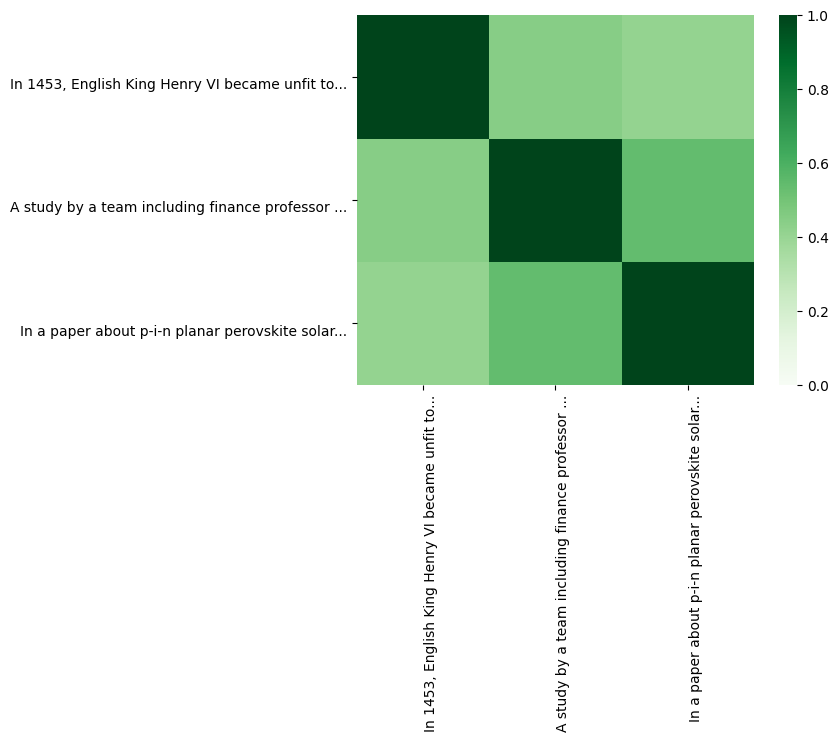

In [32]:
import pandas as pd
import seaborn as sns

response = client.models.embed_content(
    model='models/text-embedding-004',
    contents=texts,
    config=types.EmbedContentConfig(task_type='semantic_similarity'))



# Set up the embeddings in a dataframe.
df = pd.DataFrame([e.values for e in response.embeddings], index=truncated_texts)
# Matmul the df with rows and columns swapped to dot product each item
sim = df @ df.T
# Draw!
sns.heatmap(sim, vmin=0, vmax=1, cmap="Greens");

## Rich Questions
In this case, some sanitization may be required to find similar questions. Let's use all "Inferences" question from Aquarc on hard difficulty:

In [33]:
import requests

payload = {
    "test": "SAT",
    "difficulty": ["Hard"],
    "subdomain": ["Inferences"]
}
rich_questions = None

try:
    response = requests.post(
        "https://aquarc.org/sat/find-questions-v2",
        json=payload
    )
    response.raise_for_status()  # Raise exception for 4xx/5xx errors
    rich_questions = response.json()
    print(rich_questions[0])
    
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

{'questionId': 'f1bfbed3', 'id': '52a8f1cb-bff4-4dcb-b455-fbc202e8513c', 'test': 'SAT', 'category': 'Reading and Writing', 'domain': 'Information and Ideas', 'skill': 'Inferences', 'difficulty': 'Hard', 'details': '<p>Marta Coll and colleagues&rsquo; 2010 Mediterranean Sea biodiversity census reported approximately 17,000 species, nearly double the number reported in Carlo Bianchi and Carla Morri&rsquo;s 2000 census&mdash;a difference only partly attributable to the description of new invertebrate species in the interim. Another factor is that the morphological variability of microorganisms is poorly understood compared to that of vertebrates, invertebrates, plants, and algae, creating uncertainty about how to evaluate microorganisms as species. Researchers&rsquo; decisions on such matters therefore can be highly consequential. Indeed, the two censuses reported similar counts of vertebrate, plant, and algal species, suggesting that <span aria-hidden="true">______</span><span class="sr-

To "cleanse" the questions into Markdown:

In [34]:
import json

for question in rich_questions:
    question["details"] = sanitize(question["details"])
    question["question"] = sanitize(question["question"])

Markdown(rich_questions[0]["details"])

Marta Coll and colleagues’ 2010 Mediterranean Sea biodiversity census reported approximately 17,000 species, nearly double the number reported in Carlo Bianchi and Carla Morri’s 2000 census—a difference only partly attributable to the description of new invertebrate species in the interim. Another factor is that the morphological variability of microorganisms is poorly understood compared to that of vertebrates, invertebrates, plants, and algae, creating uncertainty about how to evaluate microorganisms as species. Researchers’ decisions on such matters therefore can be highly consequential. Indeed, the two censuses reported similar counts of vertebrate, plant, and algal species, suggesting that \_\_\_\_\_\_blank

Let's create a new database and add the questions:

In [35]:
DB_NAME = "rich_questions"

db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

# the passage is best used for semantic analysis
db.add(documents=[question["details"]
                  for question in rich_questions], 
       ids=[question["questionId"] for question in rich_questions])

Let's query the database with the "'How lifelike are they?'" passage to find semantic similarity. 

Define a simple function for printing:

In [36]:
def output_query(query):
    result = db.query(query_texts=[query], n_results=5)

    [all_passages] = result["documents"]

    print(f"{query}\n====================================\n")
    for passage in all_passages:
        print(passage + "\n\n")

The question unsanitized still shows semantically relevant questions:

In [37]:
query = """
<p><span role="region" aria-label="Referenced Content"><u>&ldquo;How lifelike are they?&rdquo;</u></span> Many computer animators prioritize this question as they strive to create ever more realistic environments and lighting. Generally, while characters in computer-animated films appear highly exaggerated, environments and lighting are carefully engineered to mimic reality. But some animators, such as Pixar&rsquo;s Sanjay Patel, are focused on a different question. Rather than asking first whether the environments and lighting they&rsquo;re creating are convincingly lifelike, Patel and others are asking whether these elements reflect their films&rsquo; unique stories.</p>

<p>Which choice best describes the function of the underlined question in the text as a whole?</p>

A. <p>It reflects a primary goal that many computer animators have for certain components of the animations they produce.</p>
B. <p>It represents a concern of computer animators who are more interested in creating unique backgrounds and lighting effects than realistic ones.</p>
C. <p>It conveys the uncertainty among many computer animators about how to create realistic animations using current technology.</p>
D. <p>It illustrates a reaction that audiences typically have to the appearance of characters created by computer animators.</p>
    """
output_query(query)


<p><span role="region" aria-label="Referenced Content"><u>&ldquo;How lifelike are they?&rdquo;</u></span> Many computer animators prioritize this question as they strive to create ever more realistic environments and lighting. Generally, while characters in computer-animated films appear highly exaggerated, environments and lighting are carefully engineered to mimic reality. But some animators, such as Pixar&rsquo;s Sanjay Patel, are focused on a different question. Rather than asking first whether the environments and lighting they&rsquo;re creating are convincingly lifelike, Patel and others are asking whether these elements reflect their films&rsquo; unique stories.</p>

<p>Which choice best describes the function of the underlined question in the text as a whole?</p>

A. <p>It reflects a primary goal that many computer animators have for certain components of the animations they produce.</p>
B. <p>It represents a concern of computer animators who are more interested in creating un

This semantic similarity holds mostly strong even if other details are included in the question, because that doesn't affect semantic meaning.

In [38]:
query = rich_question["question"]
output_query(query)

[Underlined]“How lifelike are they?”[End] Many computer animators prioritize this question as they strive to create ever more realistic environments and lighting. Generally, while characters in computer-animated films appear highly exaggerated, environments and lighting are carefully engineered to mimic reality. But some animators, such as Pixar’s Sanjay Patel, are focused on a different question. Rather than asking first whether the environments and lighting they’re creating are convincingly lifelike, Patel and others are asking whether these elements reflect their films’ unique stories.

Which choice best describes the function of the underlined question in the text as a whole?

A.

It reflects a primary goal that many computer animators have for certain components of the animations they produce.

B.

It represents a concern of computer animators who are more interested in creating unique backgrounds and lighting effects than realistic ones.

C.

It conveys the uncertainty among many

Completely sanitized, it has almost the same output (on my device only the order of the 4th and 5th most relevant are swapped!)

In [39]:
#passage stolen from earlier question
query = sanitize("""<p><span role="region" aria-label="Referenced Content"><u>&ldquo;How lifelike are they?&rdquo;</u></span> Many computer animators prioritize this question as they strive to create ever more realistic environments and lighting. Generally, while characters in computer-animated films appear highly exaggerated, environments and lighting are carefully engineered to mimic reality. But some animators, such as Pixar&rsquo;s Sanjay Patel, are focused on a different question. Rather than asking first whether the environments and lighting they&rsquo;re creating are convincingly lifelike, Patel and others are asking whether these elements reflect their films&rsquo; unique stories.</p>""")
output_query(query)

[Underlined]“How lifelike are they?”[End] Many computer animators prioritize this question as they strive to create ever more realistic environments and lighting. Generally, while characters in computer-animated films appear highly exaggerated, environments and lighting are carefully engineered to mimic reality. But some animators, such as Pixar’s Sanjay Patel, are focused on a different question. Rather than asking first whether the environments and lighting they’re creating are convincingly lifelike, Patel and others are asking whether these elements reflect their films’ unique stories.

Birds of many species ingest foods containing carotenoids, pigmented molecules that are converted into feather coloration. Coloration tends to be especially saturated in male birds’ feathers, and because carotenoids also confer health benefits, the deeply saturated colors generally serve to communicate what is known as an honest signal of a bird’s overall fitness to potential mates. However, ornithol

Let's try a completely different question:

In [40]:
# This question is (c) CollegeBoard 2025
query = """
<figure class="image">
   <svg aria-label="Bar graph titled Municipalities’ Responses to Inquiries about Potential Incentives for Firm. The horizontal axis has no label. 3 data categories are shown. The vertical axis is labeled Number of municipalities. It ranges from 0 to 1,300 in increments of 100. Refer to long description." height="578.7376708984375" role="img" viewbox="0 0 400 578.7376708984375" width="400" xmlns="http://www.w3.org/2000/svg">
      <g data-name="Layer 1" id="ed420550-79eb-48d4-af01-cd27cdd08afd">
         <defs>
            +
            <pattern height="100" id="bar4" patterntransform="rotate(50)" patternunits="userSpaceOnUse" width="10" x="0" y="0">
               +
               <rect fill="#CDCDCD" height="100" width="5" x="0" y="0"></rect>
               +
               <rect fill="#444444" height="100" width="5" x="5" y="0"></rect>
               +
            </pattern>
            +
         </defs>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="72" y2="72"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="72" y2="72"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 78)">1,300</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="91.23076923076923" y2="91.23076923076923"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="91.23076923076923" y2="91.23076923076923"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 97.23076923076923)">1,200</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="110.46153846153845" y2="110.46153846153845"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="110.46153846153845" y2="110.46153846153845"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 116.46153846153845)">1,100</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="129.69230769230768" y2="129.69230769230768"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="129.69230769230768" y2="129.69230769230768"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 135.69230769230768)">1,000</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="148.9230769230769" y2="148.9230769230769"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="148.9230769230769" y2="148.9230769230769"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 154.9230769230769)">900</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="168.15384615384613" y2="168.15384615384613"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="168.15384615384613" y2="168.15384615384613"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 174.15384615384613)">800</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="187.3846153846154" y2="187.3846153846154"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="187.3846153846154" y2="187.3846153846154"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 193.3846153846154)">700</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="206.6153846153846" y2="206.6153846153846"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="206.6153846153846" y2="206.6153846153846"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 212.6153846153846)">600</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="225.84615384615384" y2="225.84615384615384"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="225.84615384615384" y2="225.84615384615384"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 231.84615384615384)">500</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="245.07692307692307" y2="245.07692307692307"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="245.07692307692307" y2="245.07692307692307"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 251.07692307692307)">400</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="264.30769230769226" y2="264.30769230769226"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="264.30769230769226" y2="264.30769230769226"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 270.30769230769226)">300</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="283.53846153846155" y2="283.53846153846155"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="283.53846153846155" y2="283.53846153846155"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 289.53846153846155)">200</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="302.7692307692308" y2="302.7692307692308"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="302.7692307692308" y2="302.7692307692308"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 308.7692307692308)">100</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="385" xmlns="http://www.w3.org/2000/svg" y1="322" y2="322"></line>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="93.75999450683594" x2="105.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="322" y2="322"></line>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(87.75999450683594 328)">0</text>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="middle" transform="translate(24 197) rotate(-90)">Number of municipalities</text>
         <line fill="none" stroke="#000000" stroke-linecap="round" stroke-linejoin="round" stroke-width="0.9" x1="99.75999450683594" x2="99.75999450683594" xmlns="http://www.w3.org/2000/svg" y1="72" y2="322"></line>
         <rect fill="#B3B3B3" height="240.76923076923077" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="128.28399505615235" xmlns="http://www.w3.org/2000/svg" y="81.23076923076923"></rect>
         <rect fill="#333333" height="240" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="156.80799560546876" xmlns="http://www.w3.org/2000/svg" y="82"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(166.72799560546875 341.84) rotate(-40)" x="0" xmlns="http://www.w3.org/2000/svg" y="0">no response</text>
         <rect fill="#B3B3B3" height="39.80769230769231" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="213.85599670410159" xmlns="http://www.w3.org/2000/svg" y="282.1923076923077"></rect>
         <rect fill="#333333" height="39.42307692307692" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="242.379997253418" xmlns="http://www.w3.org/2000/svg" y="282.5769230769231"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(252.29999725341798 341.84) rotate(-40)" x="0" xmlns="http://www.w3.org/2000/svg" y="0">responded to inquiry</text>
         <rect fill="#B3B3B3" height="24.23076923076923" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="299.4279983520508" xmlns="http://www.w3.org/2000/svg" y="297.7692307692308"></rect>
         <rect fill="#333333" height="23.46153846153846" stroke="#000000" stroke-linecap="round" stroke-linejoin="mitre" stroke-width="0.9" width="28.524000549316405" x="327.9519989013672" xmlns="http://www.w3.org/2000/svg" y="298.53846153846155"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="end" transform="translate(337.8719989013672 341.84) rotate(-40)" x="0" xmlns="http://www.w3.org/2000/svg" y="0">offered incentive</text>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="middle" transform="translate(242.37999725341797 24)">Municipalities’ Responses to Inquiries </text>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="middle" transform="translate(242.37999725341797 48)">about Potential Incentives for Firm</text>
         <rect fill="none" height="71" stroke="#000000" stroke-linejoin="mitre" stroke-width="0.9" width="280.1479034423828" x="67.4260482788086" xmlns="http://www.w3.org/2000/svg" y="496.7376708984375"></rect>
         <rect fill="#B3B3B3" height="12" stroke="#000000" stroke-linejoin="mitre" stroke-width="0.9" width="12" x="74.4260482788086" xmlns="http://www.w3.org/2000/svg" y="508.7376708984375"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="top" transform="translate(96.4260482788086 520.7376708984375)"> announcement before election</text>
         <rect fill="#333333" height="12" stroke="#000000" stroke-linejoin="mitre" stroke-width="0.9" width="12" x="74.4260482788086" xmlns="http://www.w3.org/2000/svg" y="540.7376708984375"></rect>
         <text fill="#000000" font-family="Crimson Text" font-size="19.84" text-anchor="top" transform="translate(96.4260482788086 552.7376708984375)"> announcement after election</text>
      </g>
   </svg>
</figure>
<div aria-label="Long description for bar graph titled Municipalities’ Responses to Inquiries about Potential Incentives for Firm" class="sr-only" role="region">
   <ul>
      +
      <li>
         For each data category, the following bars are shown: <br/>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +
         <ul>
            +
            <li>announcement before election</li>
            +
            <li>announcement after election</li>
            +
         </ul>
         +
      </li>
      +
      <li>
         The data for the 3 categories are as follows: <br/>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +
         <ul>
            +
            <li>
               no response:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +
               <ul>
                  +
                  <li>announcement before election: 1,252</li>
                  +
                  <li>announcement after election: 1,248</li>
                  +
               </ul>
               +
            </li>
            +
            <li>
               responded to inquiry:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +
               <ul>
                  +
                  <li>announcement before election: 207</li>
                  +
                  <li>announcement after election: 205</li>
                  +
               </ul>
               +
            </li>
            +
            <li>
               offered incentive:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +
               <ul>
                  +
                  <li>announcement before election: 128</li>
                  +
                  <li>announcement after election: 122</li>
                  +
               </ul>
               +
            </li>
            +
         </ul>
         +
      </li>
      +
   </ul>
</div>
+
<p>In the United States, firms often seek incentives from municipal governments to expand to those municipalities. A team of political scientists hypothesized that municipalities are much more likely to respond to firms and offer incentives if expansions can be announced in time to benefit local elected officials than if they can’t. The team contacted officials in thousands of municipalities, inquiring about incentives for a firm looking to expand and indicating that the firm would announce its expansion on a date either just before or just after the next election. </p>

<p>Which choice best describes data from the graph that weaken the team&rsquo;s hypothesis?</p>

A. <p>A large majority of the municipalities that received an inquiry mentioning plans for an announcement before the next election didn&rsquo;t respond to the inquiry.</p>
B. <p>The proportion of municipalities that responded to the inquiry or offered incentives didn&rsquo;t substantially differ across the announcement timing conditions.&nbsp;</p>
C. <p>Only around half the municipalities that responded to inquiries mentioning plans for an announcement before the next election offered incentives.&nbsp;</p>
D. <p>Of the municipalities that received an inquiry mentioning plans for an announcement date after the next election, more than 1,200 didn&rsquo;t respond and only around 100 offered incentives.</p>
"""

output_query(query)


<figure class="image">
   <svg aria-label="Bar graph titled Municipalities’ Responses to Inquiries about Potential Incentives for Firm. The horizontal axis has no label. 3 data categories are shown. The vertical axis is labeled Number of municipalities. It ranges from 0 to 1,300 in increments of 100. Refer to long description." height="578.7376708984375" role="img" viewbox="0 0 400 578.7376708984375" width="400" xmlns="http://www.w3.org/2000/svg">
      <g data-name="Layer 1" id="ed420550-79eb-48d4-af01-cd27cdd08afd">
         <defs>
            +
            <pattern height="100" id="bar4" patterntransform="rotate(50)" patternunits="userSpaceOnUse" width="10" x="0" y="0">
               +
               <rect fill="#CDCDCD" height="100" width="5" x="0" y="0"></rect>
               +
               <rect fill="#444444" height="100" width="5" x="5" y="0"></rect>
               +
            </pattern>
            +
         </defs>
         <line fill="none" stroke="#000000" stroke-lin

In this case, sanitizing the output makes the results more semantically relevant, because the svg (garbage data to the LLM) is omitted for the most part and has minimal impact over the data. 

In [41]:
output_query(sanitize(query))

+
+
+
+
+


1,300


1,200


1,100


1,000


900


800


700


600


500


400


300


200


100


0
Number of municipalities



no response


responded to inquiry


offered incentive
Municipalities’ Responses to Inquiries 
about Potential Incentives for Firm


 announcement before election

 announcement after election

+* For each data category, the following bars are shown:   
   +
  ++ announcement before election
  ++ announcement after election
  ++
+* The data for the 3 categories are as follows:   
   +
  ++ no response: +
    +- announcement before election: 1,252
    +- announcement after election: 1,248
    ++
  ++ responded to inquiry: +
    +- announcement before election: 207
    +- announcement after election: 205
    ++
  ++ offered incentive: +
    +- announcement before election: 128
    +- announcement after election: 122
    ++
  ++
+

+

In the United States, firms often seek incentives from municipal governments to expand to those municipalities. A team of politica

By sanitizing the output, even though you are essentially trimming HTML and data the LLM can't understand, you can end up with less relevant answers. Therefore, it is important to always sanitize the questions of unnecessary HTML that tampers with the semantic meaning.

## Limitations
The relevance of the semantic question finder is limited by the model's understanding of the questions' underlying meanings. The embeddings may require fine-tuning so that the details relevant to the SAT are captured more precisely. 

# Evaluating Usability of SAT Specs Data
This is a demo of an attempted RAG pipeline using the SAT specs pdf. It did not work, however it provided some insights on how specific the PDF needs to be. The model cannot embed and find relevant chunks if there is a lot of noise.

In [42]:
from google.genai.types import GenerateContentConfig

question = {
        "question" : """
In a paper about p-i-n planar perovskite solar cells (one of several perovskite cell architectures designed to collect and store solar power), Lyndsey McMillon-Brown et al. described a method for fabricating the cell’s electronic transport layer (ETL) using a spray coating. Conventional ETL fabrication is accomplished using a solution of nanoparticles. The process can result in a loss of up to 80% of the solution, increasing the cost of manufacturing at scale—an issue that may be obviated by spray coating fabrication, which the researchers describe as “highly reproducible, concise, and practical.”

What does the text most strongly suggest about conventional ETL fabrication?
A. It is less suitable for manufacturing large volumes of planar p-i-n perovskite solar cells than an alternative fabrication method may be.
B. It is more expensive when manufacturing at scale than are processes for fabricating ETLs used in other perovskite solar cell architectures.
C. It typically entails a greater loss of nanoparticle solution than do other established approaches for ETL fabrication.
D. It is somewhat imprecise and therefore limits the potential effectiveness of p-i-n planar perovskite solar cells at capturing and storing solar power.
""",
        "rationale" : """
Choice A is the best answer. Conventional solar cell fabrication increases “the cost of manufacturing at scale,” but spray coating might get rid of that problem.

Choice B is incorrect. This is not completely supported by the text. While it’s true that conventional ETL fabrication is expensive at scale, there’s nothing in the text that mentions other perovskite solar cell architectures. Choice C is incorrect. This choice does not match the text. Only one conventional method of ETL fabrication is described, so we can’t compare the solution loss in this method to that of other conventional methods. Choice D is incorrect. This choice isn’t supported by the text. The text never suggests that the effectiveness of solar cells changes based on their method of fabrication. 
""",
        "user_answer" : "C",
        "user_rationale": "Isn't the new method of ETL fabrication the same as the 'established methods'",
}

response = client.models.generate_content(
    model="gemini-2.0-flash-001",
    contents=f"{question['question']} {question['rationale']}\n The user got: {question['user_answer']}\n {question['user_rationale']}",
    config=GenerateContentConfig(
        system_instruction=[
            "You are an SAT expert tutor. Analyze questions using the official SAT framework. ",
            "Help students by:\n",
            "1. Identifying question type and skills tested\n",
            "2. Explaining why answers are correct/incorrect\n",
            "3. Providing actionable improvement strategies\n",
            "Use formal but friendly language. Reference the SAT specs when possible.",
        ]
    ),
)


Markdown(response.text)

Okay, I can definitely see why you chose option C, and I agree that it's a very tempting answer! Let's break down why option A is better and why option C might be a bit of a trap.

**Here's the breakdown:**

*   **Question Type:** This is a Command of Evidence question, specifically an inference question. We need to find the answer choice that is **most strongly suggested** by the text. This means the answer might not be directly stated, but it's the most logical conclusion we can draw.

*   **Why Choice A is Best:**
    *   The passage explicitly states the conventional method "can result in a loss of up to 80% of the solution, increasing the cost of manufacturing at scale."
    *   It then contrasts this with spray coating, which the researchers describe as "highly reproducible, concise, and practical." The passage implies this new method addresses the cost issue.
    *   Therefore, it's strongly suggested that the conventional method's high cost at scale makes it **less suitable** than the alternative (spray coating).

*   **Why Choice C is Incorrect:**
    *   This is where the nuance comes in. Choice C states: "It typically entails a greater loss of nanoparticle solution than do **other established approaches** for ETL fabrication."
    *   The passage **only describes ONE conventional method** (the nanoparticle solution method).
    *   While spray coating may be 'practical', there is nothing that suggests it is an established method.
    *   We can't compare the solution loss of this specific conventional method to "other established approaches" because the passage doesn't give us information about other established approaches.
    *   We also do not know if "conventional ETL fabrication" is the same as "established approaches".

**SAT Skills in Play:**

*   **Careful Reading:** The SAT loves to test whether you're reading closely and paying attention to the precise wording.
*   **Inference vs. Direct Statement:** You need to distinguish between what the text explicitly says and what it implies.
*   **Avoiding Assumptions:** Don't bring in outside knowledge or make assumptions that aren't supported by the text.

**Actionable Improvement Strategy:**

1.  **Focus on Explicit Mentions:** When answering inference questions, make sure your answer is firmly based on something stated in the text.
2.  **Qualify Your Answers:** Use words like "suggests," "implies," or "indicates" when justifying your answer. This acknowledges that you're making an inference, not just quoting the text.
3.  **Beware of "Close But Not Quite":** The SAT often includes answer choices that are partially correct or seem related to the topic but don't directly answer the question based on the text.

I hope this helps clarify why Choice A is the better answer! Let me know if you have any other questions.


## Parse PDF
The following code uses lossy conversion to turn the PDF into readable text.

Information like tables and images will be lost in the process, as demonstrated by the following snippet.

In [43]:
from PyPDF2 import PdfReader
from io import BytesIO
import requests

url = "https://www.w3.org/WAI/WCAG20/Techniques/working-examples/PDF20/table.pdf"
response = requests.get(url)
pdf_bytes = BytesIO(response.content)

text = ""
pdf_reader = PdfReader(pdf_bytes)
for page in pdf_reader.pages:
    text += page.extract_text()

print(text[0:1000])

Example table  
This is an example of a data table. 
Disability 
Category Participants  Ballots 
Completed  Ballots 
Incomplete/  
Terminated  Results  
Accuracy  Time to 
complete 
Blind  5 1 4 34.5%, n=1  1199 sec, n=1  
Low Vision  5 2 3 98.3% n=2  
(97.7%, n=3)  1716 sec, n=3  
(1934 sec, n=2)  
Dexterity  5 4 1 98.3%, n=4  1672.1 sec, n=4  
Mobility  3 3 0 95.4%, n=3  1416 sec, n=3  
 


In [44]:
# Download the PDF using requests
url = "https://satsuite.collegeboard.org/media/pdf/assessment-framework-for-digital-sat-suite.pdf"

response = requests.get(url)
pdf_bytes = BytesIO(response.content)

print(type(pdf_bytes))

specs_text = ""
pdf_reader = PdfReader(pdf_bytes)
for page in pdf_reader.pages:
    specs_text += page.extract_text()

print(specs_text[0:1000])

<class '_io.BytesIO'>
Assessment Framework 
for the Digital SAT® SuiteAssessment Framework 
for the Digital SAT® Suite
Version 3.01, August 2024
About College Board
College Board reaches more than 7 million students a year, helping them 
navigate the path from high school to college and career. Our not-for-
profit membership organization was founded more than 120 years ago. 
We pioneered programs like the SAT® and AP® to expand opportunities 
for students and help them develop the skills they need. Our BigFuture® 
program helps students plan for college, pay for college, and explore 
careers. Learn more at cb.org .
Suggested Citation:  College Board. 2024. Assessment Framework for the 
Digital SAT Suite , version 3.01 (August 2024). New Y ork: College Board.
© 2024 College Board. College Board, Advanced Placement, AP , BigFuture, Landscape, Pre-AP , SAT, and 
the acorn logo are registered trademarks of College Board. AP Potential, Bluebook, Connections, PSAT, 
Skills Insight, Student S

This text data might be too big for the model to contain within the prompt.

In [45]:
client.models.count_tokens(
    model=model, contents=specs_text
).total_tokens

153273

That's a pretty significant size! The only way to incorporate the PDF properly is to chunk it.

## Chunk the Parsed PDF
In order to use the PDF, we need to "chunk" it so bits of relevant information can be accessed at a time. In order to maximize efficiency, a vector search database will be used, as the likelihood that any key words in the question will appear on the SAT is effectively zero. 

In [46]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1024,
    chunk_overlap=102,
    length_function=len,
    is_separator_regex=False,
)

chunked_specs_text = text_splitter.split_text(specs_text)

Check out the chunks:

In [47]:
print(len(chunked_specs_text))
print(chunked_specs_text[0])

702
Assessment Framework 
for the Digital SAT® SuiteAssessment Framework 
for the Digital SAT® Suite
Version 3.01, August 2024
About College Board
College Board reaches more than 7 million students a year, helping them 
navigate the path from high school to college and career. Our not-for-
profit membership organization was founded more than 120 years ago. 
We pioneered programs like the SAT® and AP® to expand opportunities 
for students and help them develop the skills they need. Our BigFuture® 
program helps students plan for college, pay for college, and explore 
careers. Learn more at cb.org .
Suggested Citation:  College Board. 2024. Assessment Framework for the 
Digital SAT Suite , version 3.01 (August 2024). New Y ork: College Board.
© 2024 College Board. College Board, Advanced Placement, AP , BigFuture, Landscape, Pre-AP , SAT, and 
the acorn logo are registered trademarks of College Board. AP Potential, Bluebook, Connections, PSAT,


## Initialize ReAct agent
The model will instead be a ReAct agent and figure out what to search up and call that tool as an extension and we will see what happens

We will start by finding a gemini model for embedding.

Now let's create a Chroma database client and add the document embeddings

In [48]:
import chromadb

SPECS_DB_NAME = "specs"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
#print(chroma_client.list_collections())
db = chroma_client.get_or_create_collection(name=SPECS_DB_NAME, embedding_function=embed_fn)
for i in range(int(len(chunked_specs_text) / 100)):
    db.add(documents=chunked_specs_text[i:100+i], ids=[str(i + j) for j in range(100)])

Check out the database

In [49]:
db.count()
db.peek(1)

{'ids': ['0'],
 'embeddings': array([[ 5.80166355e-02,  4.36070710e-02, -5.12756817e-02,
         -1.44314906e-03,  2.73717772e-02,  4.12952006e-02,
          5.71677238e-02,  7.64632318e-03,  9.56675038e-03,
         -5.80519577e-03, -4.39782254e-02,  9.93977953e-03,
          3.03114597e-02,  3.39544937e-02, -7.10375309e-02,
          1.01664122e-02,  2.03551948e-02,  5.44842966e-02,
         -1.12781808e-01, -2.91494676e-03, -2.88882591e-02,
         -3.38051245e-02, -1.49710365e-02, -1.39160426e-02,
         -1.64779034e-02,  7.98442122e-03,  7.00960010e-02,
          1.01699783e-02,  1.97551977e-02, -3.44269574e-02,
          2.98777758e-03,  9.17043630e-03, -2.51114983e-02,
         -8.72381590e-03,  7.50523322e-05,  3.42415981e-02,
         -2.42317207e-02, -3.20444927e-02,  7.41561651e-02,
         -4.53105606e-02, -4.95616272e-02, -4.72334400e-03,
         -1.52662601e-02, -1.15578976e-02, -2.57304776e-02,
          5.48221776e-03,  6.22319020e-02,  5.05198240e-02,
         -1

Let's look for *Information and Ideas* and see what relevant information the vector database finds on it.

In [50]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "What is the weighting of Information and Ideas?"

result = db.query(query_texts=[query], n_results=1)
[all_passages] = result["documents"]


Markdown(all_passages[0])

4.1.8. Word Count  ..................................................................................................................... 79
4.1.9. Informational Graphics  ............................................................................................... 79
4.1.10. T ext Complexity  .......................................................................................................... 79
4.2 Definitions  ..................................................................................................................................... 79
4.2.1. Construct  ......................................................................................................................... 79
4.2.2. Claims  ................................................................................................................................ 80
4.3 Content Domain Structure  ...................................................................................................... 81

Now let's look for something more generic, like scientific vocabulary or weighting of passages.

In [51]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "What scientific stuff are we tested on?"

result = db.query(query_texts=[query], n_results=2)
[all_passages] = result["documents"]

Markdown(all_passages[0])

standardized testing as well as many families, educators, and policymakers have 
raised concerns about the extent to which U.S. students are tested as part of 
K–12 education. Polling has suggested that the public’s doubts about the value of 
standardized testing in schools have grown over time, and the necessary relaxation 
of federal testing requirements under the successor Every Student Succeeds Act 
during the 2019–2020 and, to a lesser extent, 2020–2021 pandemic years has 
further contributed to those doubts. (See Bruno and Goldhaber 2021 for a brief 
recent overview.)A Living 
Document
This release of the Assessment 
Framework for the Digital SAT 
Suite  includes authoritative, 
up-to-date information about 
the digital suite. As College 
Board continues to research and 
implement the tests, updates 
will be made to this document 
(and disseminated through other 
means, such as our website, 
sat.org/digital ) to ensure that 
readers have as complete and 
accurate a picture as possible.

The information captured by the embedding model is not relevant to the question. Perhaps more results solve the problem?

In [52]:
result = db.query(query_texts=[query], n_results=2)
[all_passages] = result["documents"]

[print(passage) for passage in all_passages]

standardized testing as well as many families, educators, and policymakers have 
raised concerns about the extent to which U.S. students are tested as part of 
K–12 education. Polling has suggested that the public’s doubts about the value of 
standardized testing in schools have grown over time, and the necessary relaxation 
of federal testing requirements under the successor Every Student Succeeds Act 
during the 2019–2020 and, to a lesser extent, 2020–2021 pandemic years has 
further contributed to those doubts. (See Bruno and Goldhaber 2021 for a brief 
recent overview.)A Living 
Document
This release of the Assessment 
Framework for the Digital SAT 
Suite  includes authoritative, 
up-to-date information about 
the digital suite. As College 
Board continues to research and 
implement the tests, updates 
will be made to this document 
(and disseminated through other 
means, such as our website, 
sat.org/digital ) to ensure that 
readers have as complete and 
accurate a picture as pos

[None, None]

There are unnecessary details in the original PDF. "Garbage in, garbage out" 
The solution is perhaps to distill the relevant information from the PDF into a text document, and look for other relevant information.
# Synthesized Workflow
Now let's merge the features of the individual features into one!
Since the SAT Specs data was not helpful to the agent and the Question Finder does not require anything from the agent (until later iterations), the workflow for the agent will consist of a system prompt outlining context, the debate-style evaluation prompt and the prompt for multiple thinking processes. The user will be able to chat with the model normally to ask follow-up questions.

## How it (may) look from the website's perspective
The user will first get a question wrong. They'll press a button to launch the AI. The bot will ask, "Why did you pick option X?" and the user will enter their rationale. The debate-style prompt will be used for that purpose only. A button will be available for ToT processing, and the respective prompt will be subsituted for the query; at all other times, the user can ask specific questions or talk to the bot in an otherwise normal way.

In essence, it allows a conversation to look like this: 

```
Bot: Why did you pick option C?
User: [...]
Bot: Here's why answer C could be right: [...] And why A is right instead: [...]
User: Maybe I should read through it slower?
Bot: Absolutely! [...]
User: [Generate Possible Reasoning Chain]
Bot: [...]
```

## Implementation
Let's first define an adaptable system prompt for the following workflow (this merged system prompt can also be evaluated against other variations! It isn't necessary for the scope of the notebook, so I won't include that here.)

In [53]:
system_prompt = """
You are an expert SAT tutor and answer analyst with two core capabilities:

1. **Answer Evaluation Mode** (Triggered by answer comparison requests):
- Evaluate both correct and student answers
- Present strongest arguments FOR and AGAINST the student's answer
- Explain why the correct answer is superior with textual evidence

2. **Cognitive Analysis Mode** (Triggered by student mistake analysis requests):
- Analyze SAT questions with official rationales
- Identify cognitive biases in student thinking
- Generate multiple plausible thinking processes
- Output JSON array of thought pathways

Always maintain capacity for:
- Contextual follow-up questions
- Additional analysis layers on existing content
- Seamless switching between modes based on query type
"""

The evaluation prompt:

In [54]:
final_eval_prompt = """
Evaluate both the correct answer and the user's answer as potential responses to the question.

*   Present the strongest possible argument *in favor* of the user's answer.
*   Present the strongest possible argument *against* the user's answer.
*   Explain why, ultimately, the correct answer is the superior choice based on textual evidence.
"""

The prompt for multiple thinking processes:

In [55]:
final_thinking_prompt = """You are an expert SAT tutor analyzing a student's mistake on an SAT question. You are provided with:

1. The SAT question, including the text, answer choices, and the correct answer.
2. The official rationale for the correct answer and why the other choices are incorrect.
3. The student's chosen answer and their rationale for choosing that answer.
4. An argument contrasting the user's answer with the correct answer.

Consider potential cognitive biases (e.g., confirmation bias, anchoring bias, availability heuristic) that might have influenced the student's decision-making process. Develop multiple step-by-step thinking processes that incorporate these biases, leading to both the student's answer and the correct answer.

Output a JSON array of objects. Each object represents a distinct thinking process and whether it leads to the user's answer or the correct answer. Include as many plausible thinking processes as possible, even if they seem obvious.

Format:
```json
[
    {
        "thinking_process": "[Here you will define a process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Here you will define another process step by step to get one of the answers]",
        "leads_to": "user" | "correct"
    },
    {
        "thinking_process": "[Include as many of these as possible!]",
        "leads_to": "user" | "correct"
    },
]
```
"""

Here's a simulated workflow (context handled manually to stay consistent with above client objects and to simulate handling in the real backend):

In [56]:
# Initialize conversation history
conversation_history = []

# First Request (Evaluation)
eval_content = {
    "role": "user",
    "parts": [{
        "text": f"{final_eval_prompt}: \n{question['question']} {question['rationale']}\n The user got: {question['user_answer']}\n {question['user_rationale']}"
    }]
}

response1 = client.models.generate_content(
    model=model,
    contents=[*conversation_history, eval_content],
    config=GenerateContentConfig(
        system_instruction=[system_prompt]
    ),
)

# Update history with first interaction
conversation_history.extend([
    eval_content,
    {"role": "model", "parts": [{"text": response1.text}]}
])

# Second Request (Analysis with JSON Schema)
analysis_content = {
    "role": "user", 
    "parts": [{
        "text": final_thinking_prompt + "\n" + str(question)
    }]
}


response2 = client.models.generate_content(
    model="gemini-2.0-flash-001",
    contents=[*conversation_history, analysis_content],
    config=GenerateContentConfig(
        system_instruction=[system_prompt],  # Fixed typo: sytem_prompt -> system_prompt
        temperature=0.1,
        response_mime_type="application/json",
        response_schema={
  "title": "SAT Analysis Response",
  "description": "Response format for SAT mistake analysis using multiple thinking processes",
  "type": "array",
  "minItems": 3,
  "maxItems": 8,
  "items": {
    "type": "object",
    "properties": {
      "thinking_process": {
        "type": "string",
        "description": "Step-by-step explanation of cognitive path leading to an answer choice",
        "minLength": 50,
        "maxLength": 500
      },
      "leads_to": {
        "type": "string",
        "enum": ["user", "correct"],
        "description": "Indicates whether this thinking process leads to the student's answer or the correct answer"
      }
    },
    "required": ["thinking_process", "leads_to"],

  }
        }
    ),
)

# Update history with second interaction
conversation_history.extend([
    analysis_content,
    {"role": "model", "parts": [{"text": response2.text}]}
])

# Third Request (Simplification)
simplify_content = {
    "role": "user",
    "parts": [{"text": "Explain the confirmation bias example in simpler terms"}]
}

response3 = client.models.generate_content(
    model=model,
    contents=[*conversation_history, simplify_content],
    config=GenerateContentConfig(
        system_instruction=[system_prompt]
    ),
)

# Final history state
conversation_history.extend([
    simplify_content,
    {"role": "model", "parts": [{"text": response3.text}]}
])

Markdown(response3.text)

Okay, let's break down the confirmation bias example from the JSON array in simpler terms. It's this one:

```json
{
    "thinking_process": "1. Read the question and quickly scan the answer choices. 2. Notice that choice C mentions 'greater loss of nanoparticle solution,' which directly relates to the 80% loss mentioned in the passage. 3. Anchor on this seemingly relevant detail. 4. Without carefully considering the comparative element ('than do other established approaches'), select C based on the availability of the 'solution loss' detail.",
    "leads_to": "user"
}
```

Here's the breakdown in plain English:

*   **The Setup:** You read the question and the passage. You quickly spot that the passage mentions an "80% loss of nanoparticle solution."

*   **The Bias (Confirmation Bias):** Your brain *really* likes it when it finds information that seems to match something it already knows. In this case, you see "loss of nanoparticle solution" in answer choice C, and because you *remembered* that detail from the passage, your brain says, "Aha! That *must* be important! That *must* be the right answer!" You're *confirming* your initial impression that the solution loss is the key thing.

*   **The Mistake:** Because your brain is so happy to find that confirming detail, you *stop thinking critically*. You don't carefully read the *entire* answer choice C. You skim over the phrase "than do other established approaches" and don't realize that the passage *doesn't* give you any information to compare the solution loss to other methods. You're so focused on confirming your initial impression that you miss a crucial detail that would make you realize the answer is wrong.

*   **In essence:** Confirmation bias made you latch onto a detail you remembered and ignore other parts of the answer (and the passage) that would have shown you the answer was incorrect. You sought out evidence that supported your initial impression and failed to look for evidence that contradicted it.


# Conclusion
Since the information about the SAT and its nuances aren't available online, data has to be collected over time to come up with this RAG pipeline. This feature will be implemented in the months to come.

(c) Aquarc 2025

Some parts of this Codelab are (c) Google 2025 under the Apache License.

Questions are (c) CollegeBoard 2025. 